In [1]:
import numpy
import gzip
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import numba
import copy
import glob
from numba import njit
import pandas
import glob
import psutil
import json
import requests

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

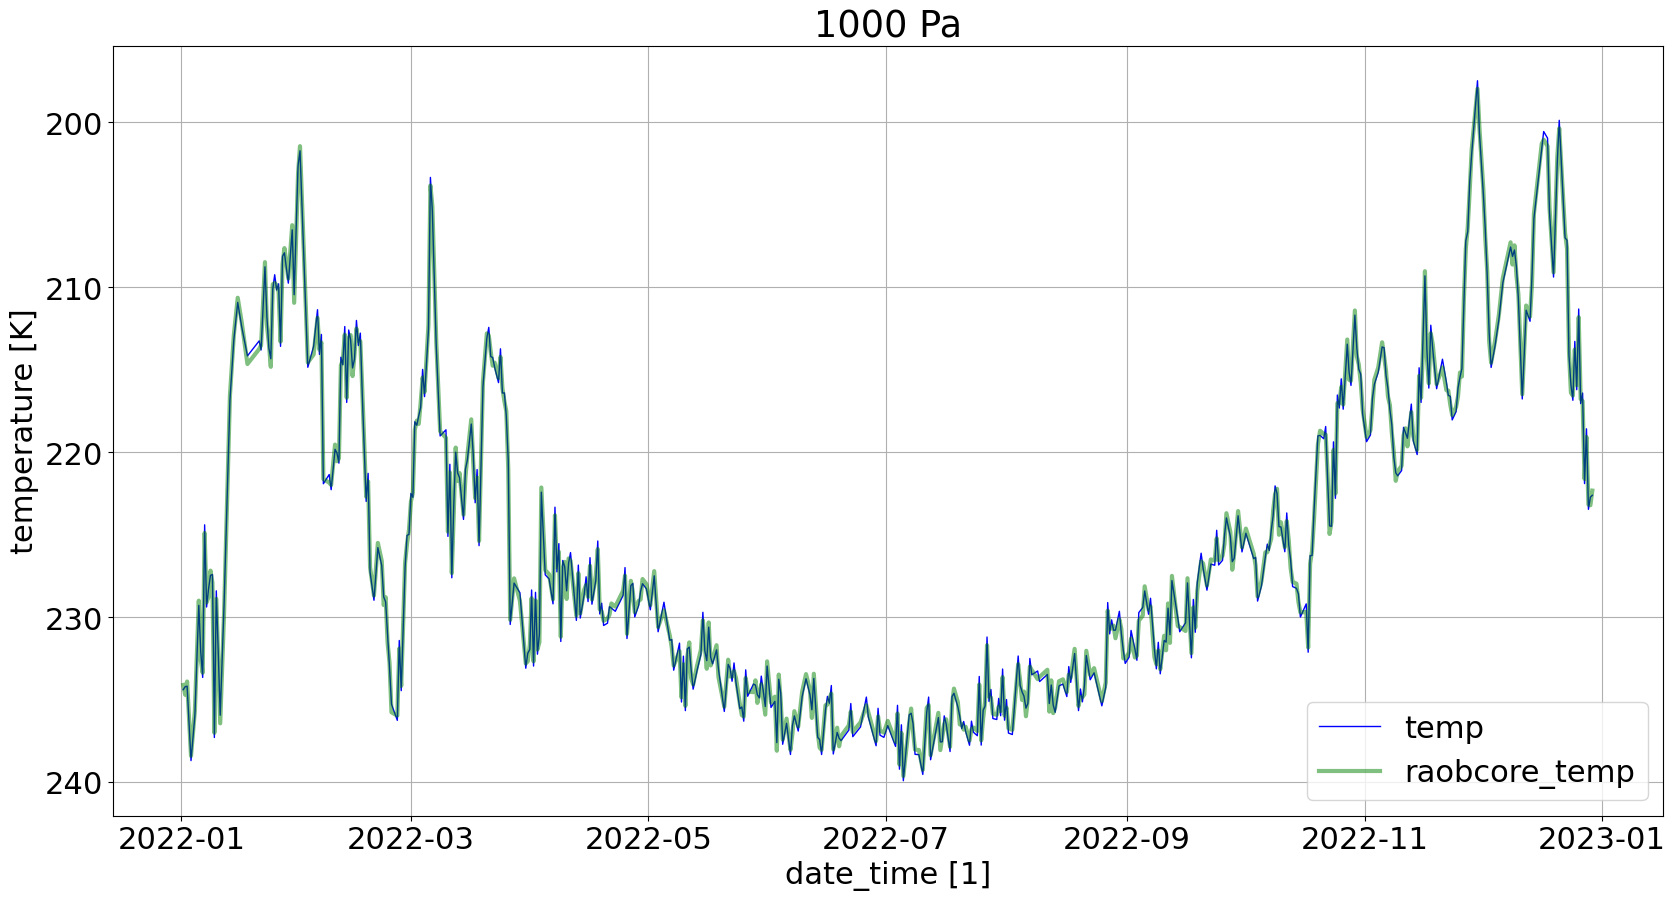

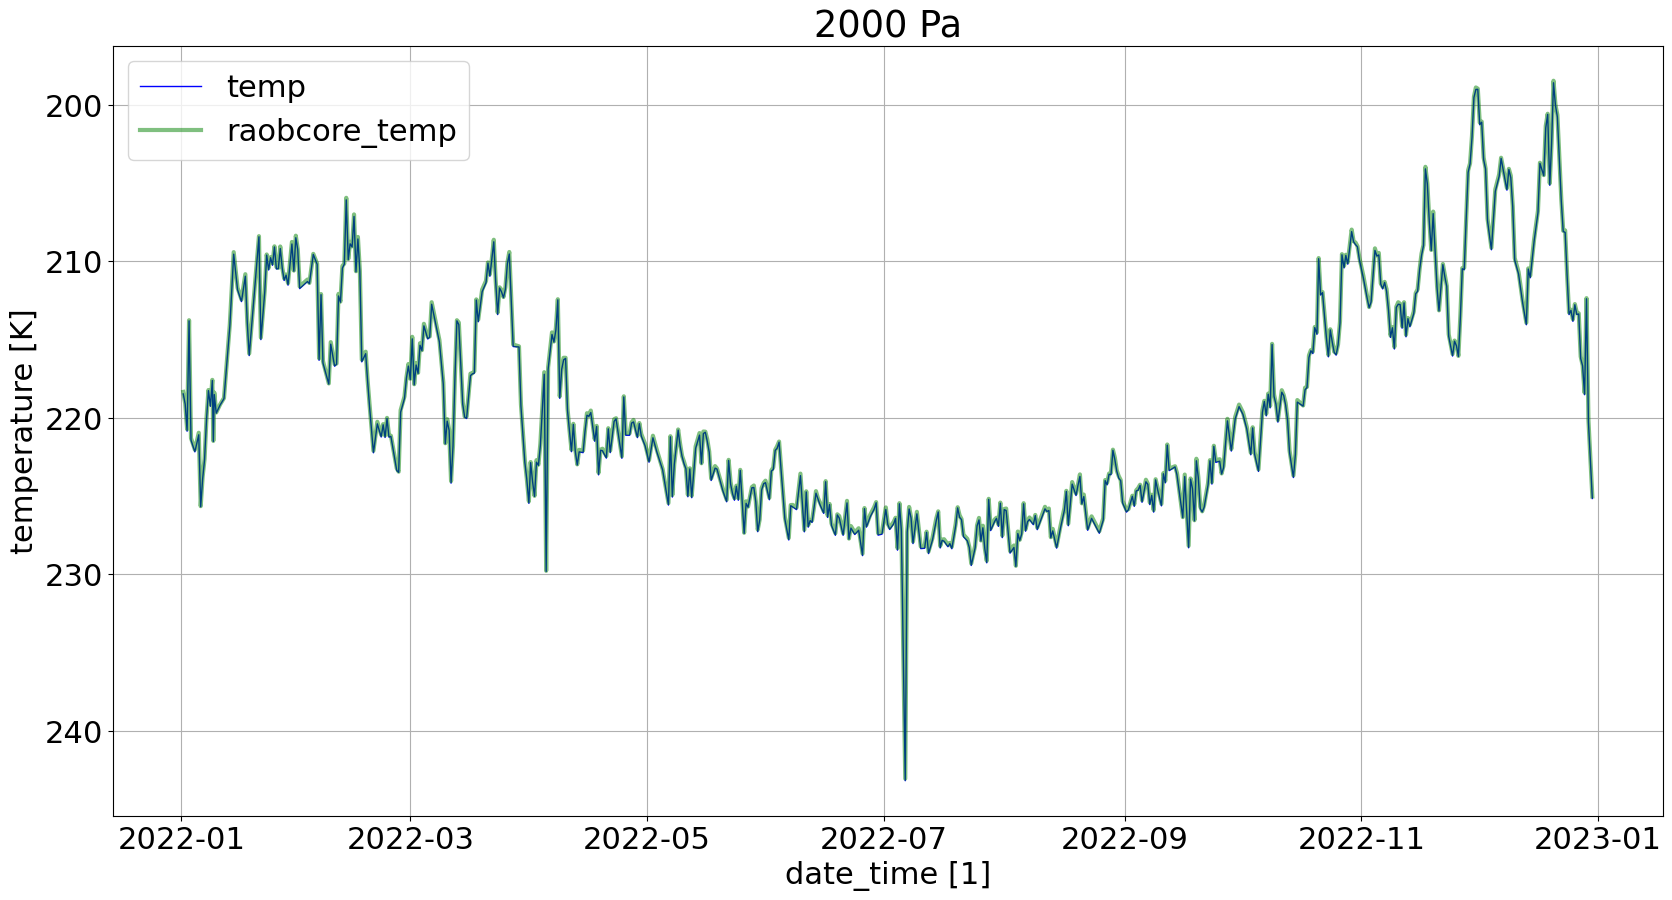

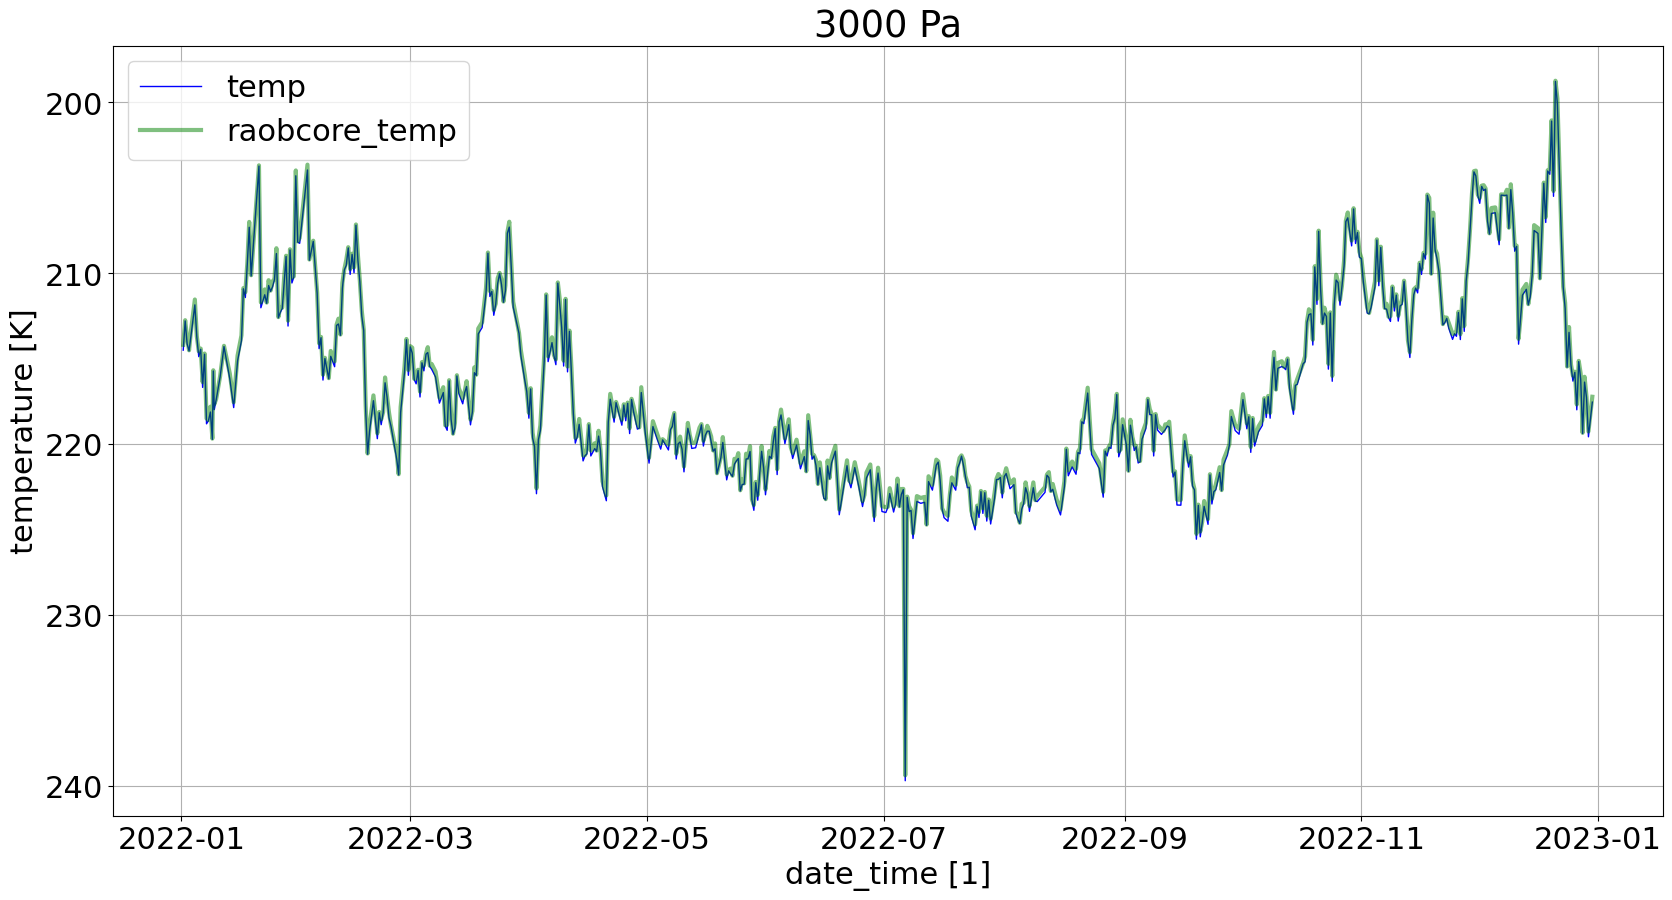

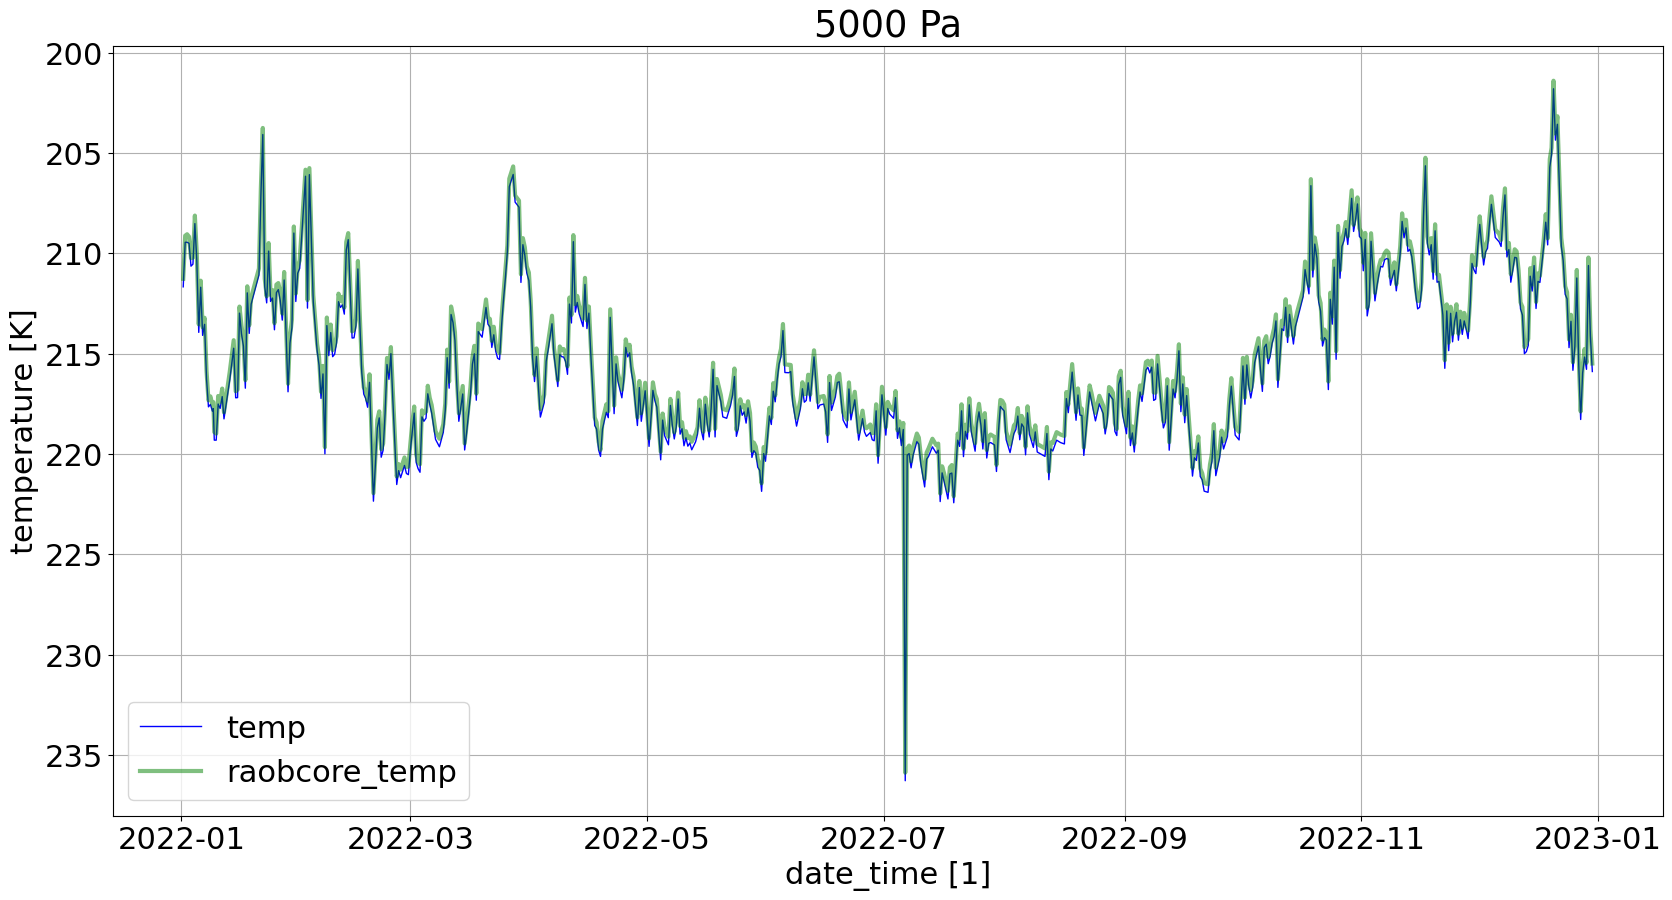

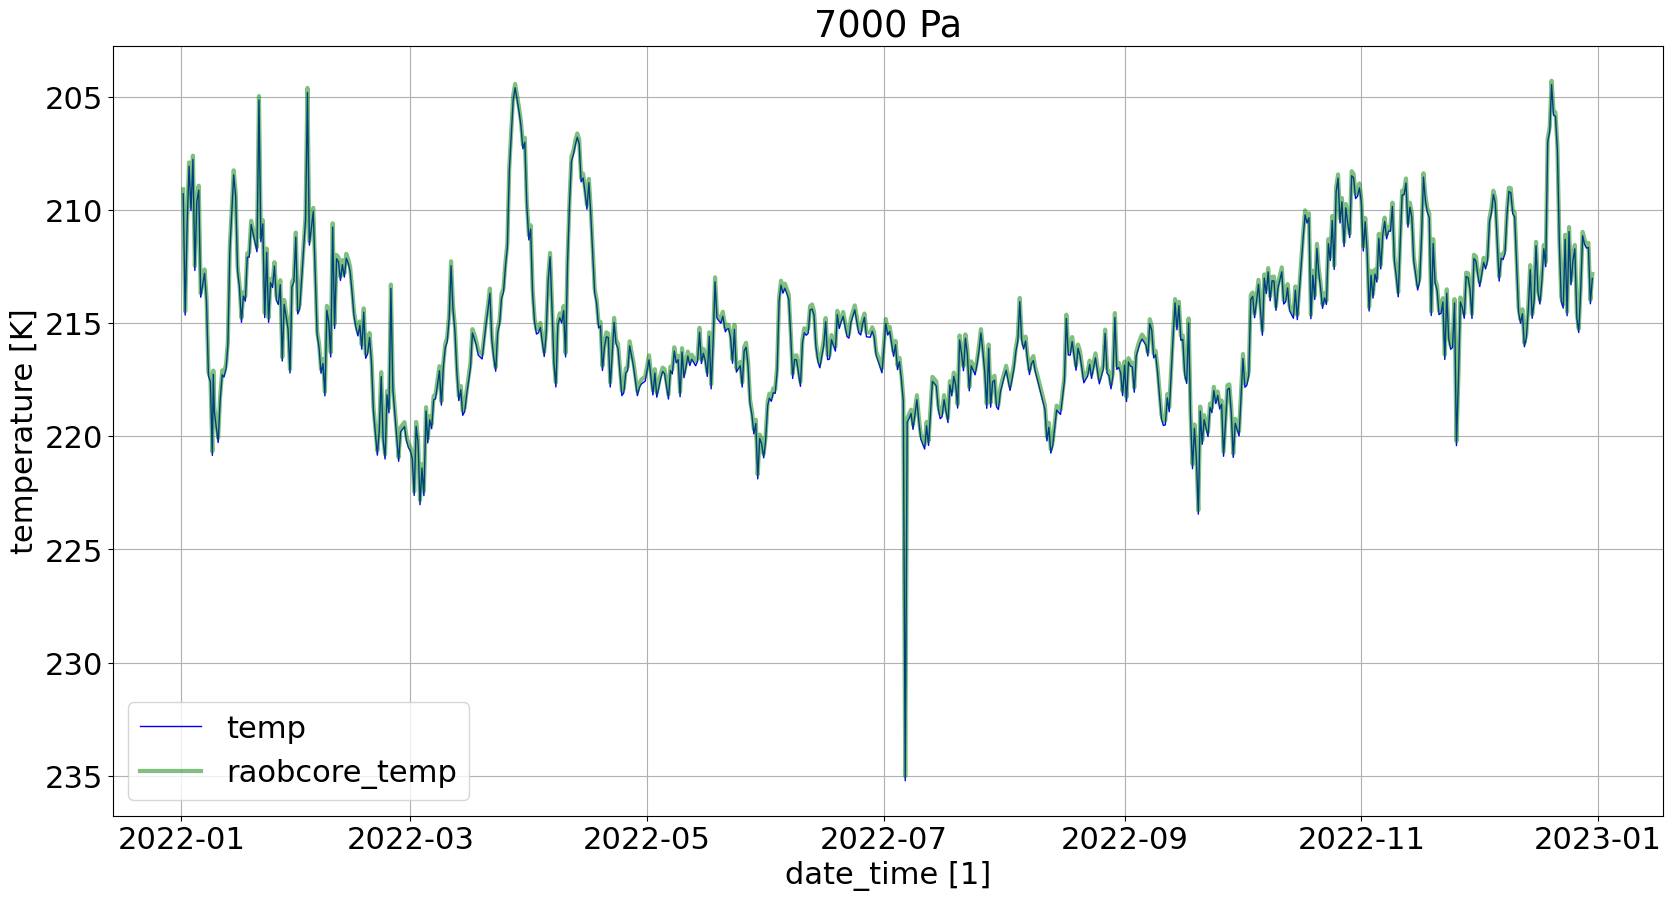

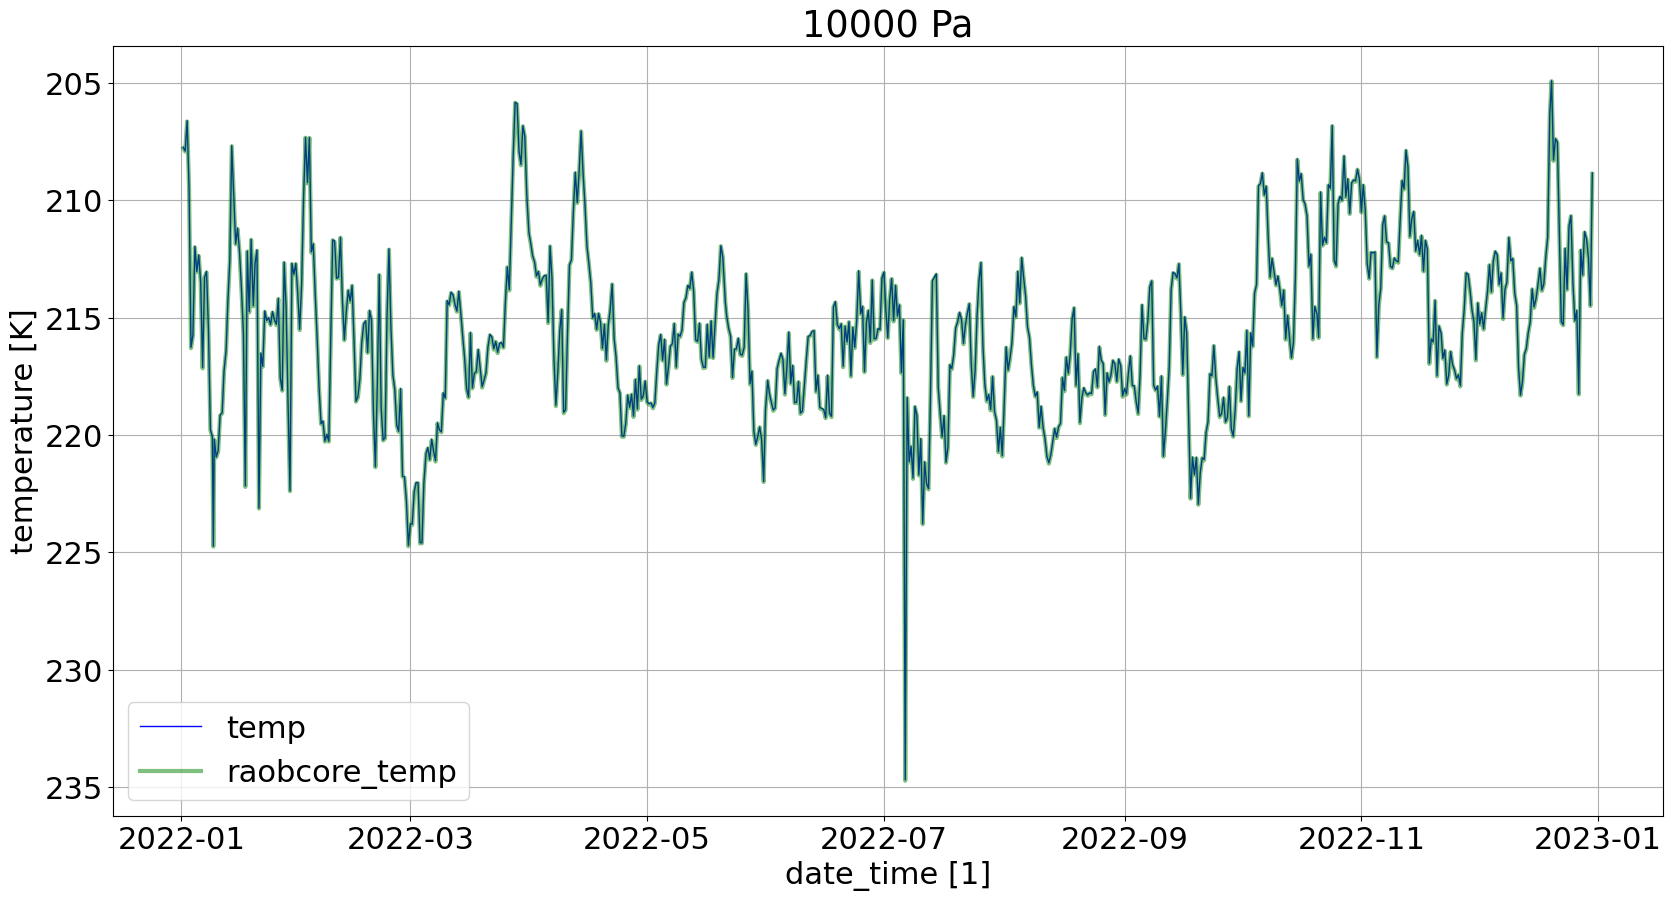

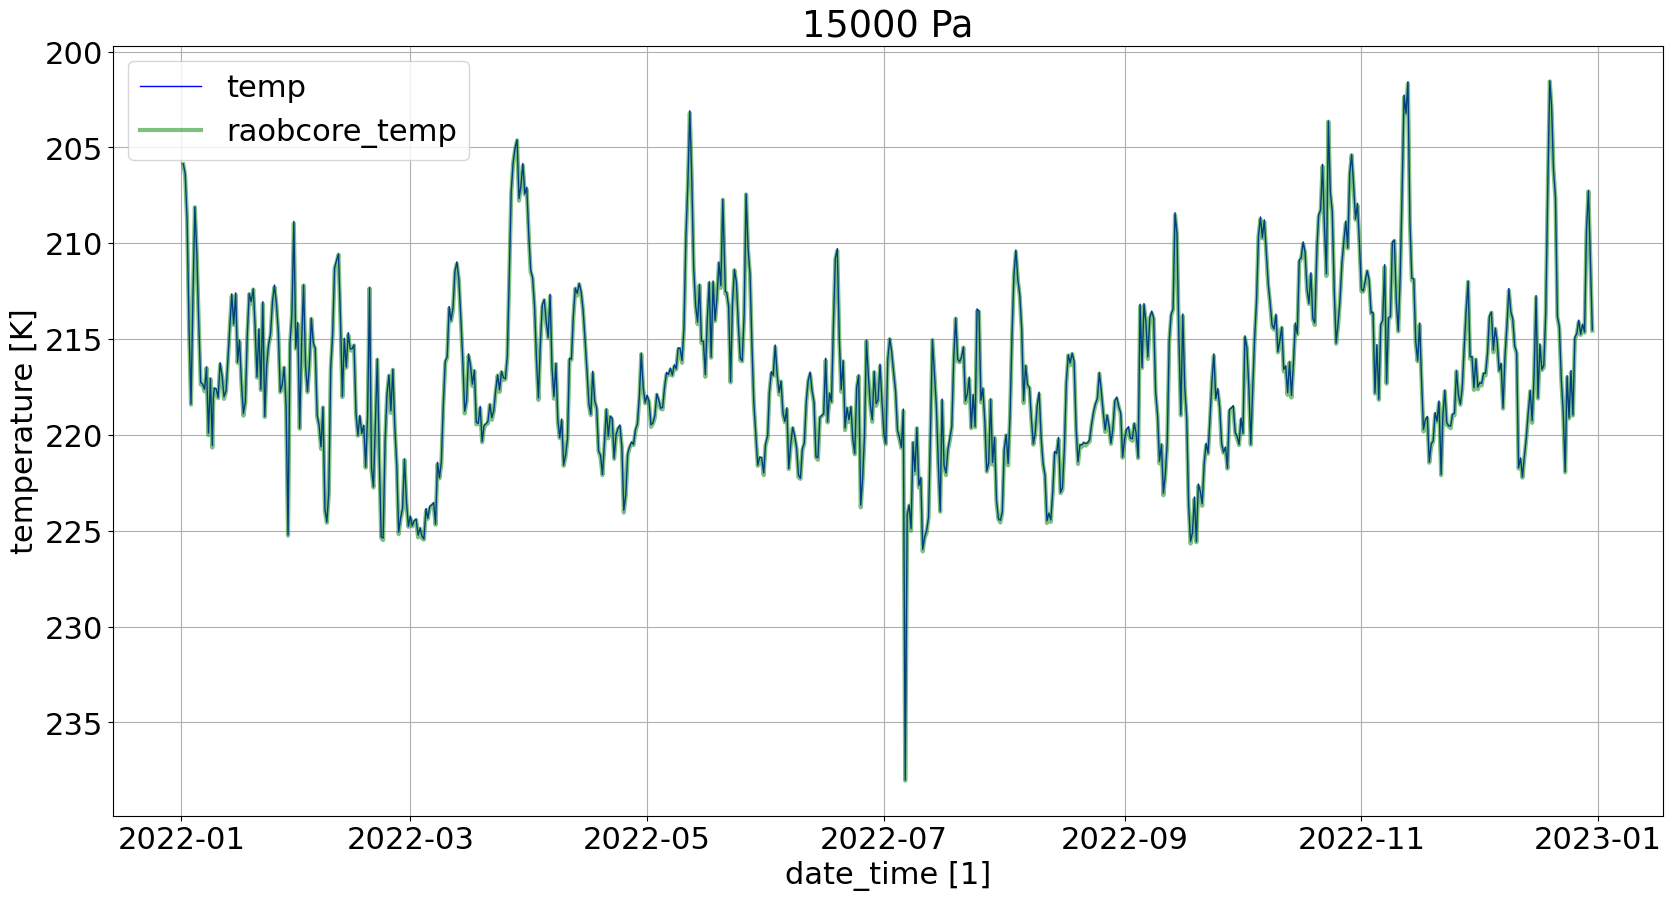

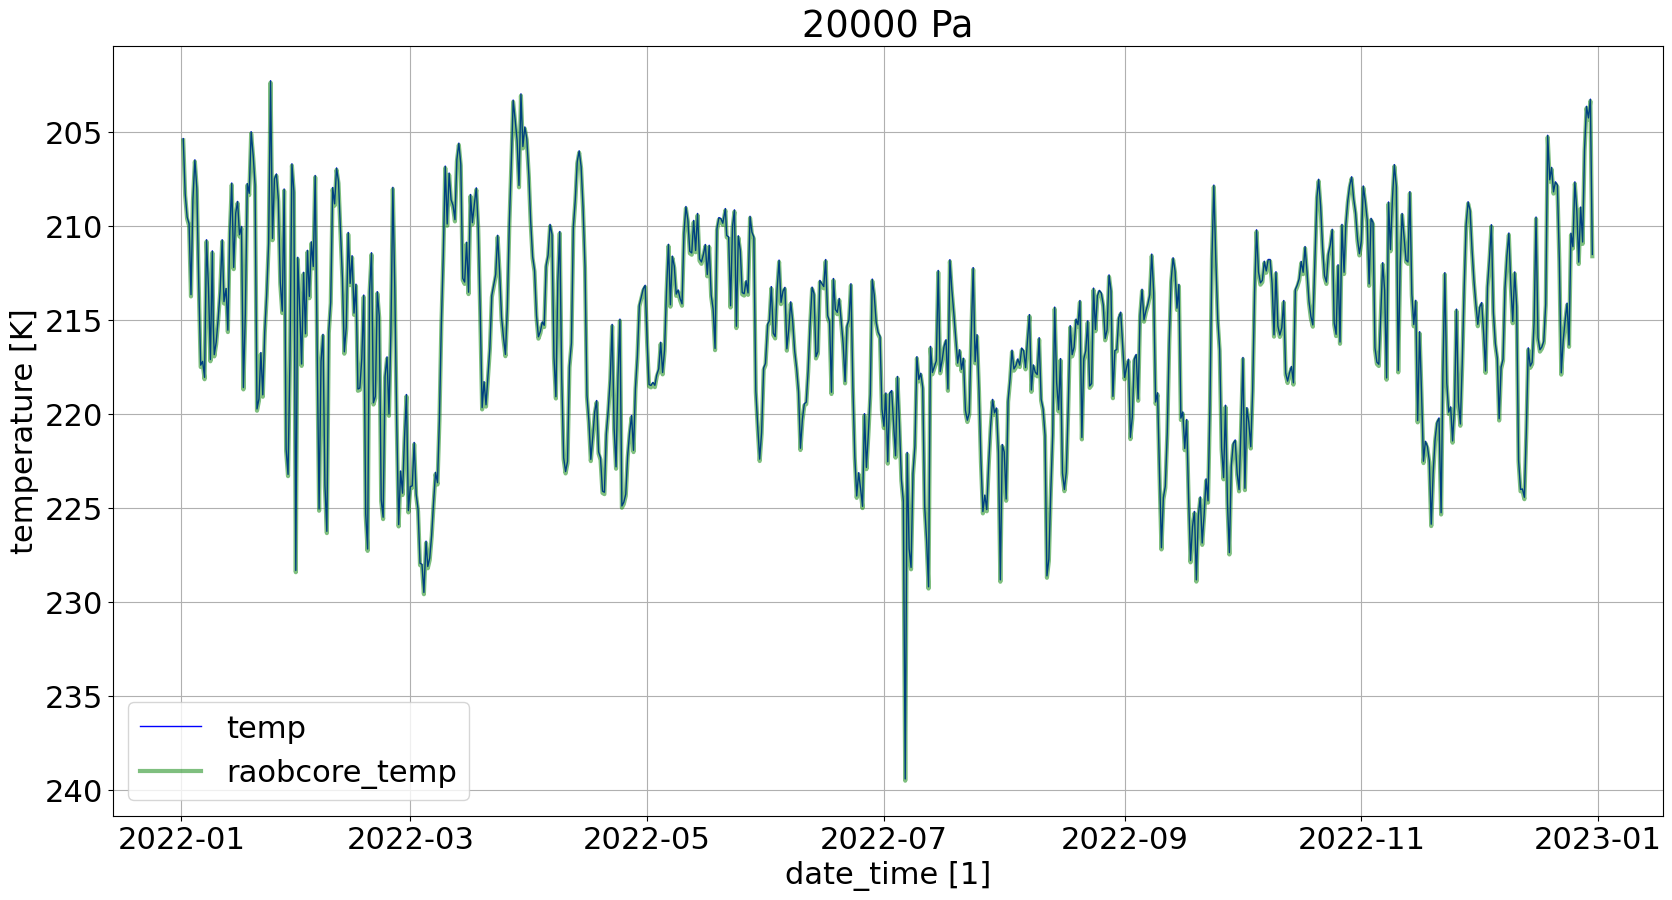

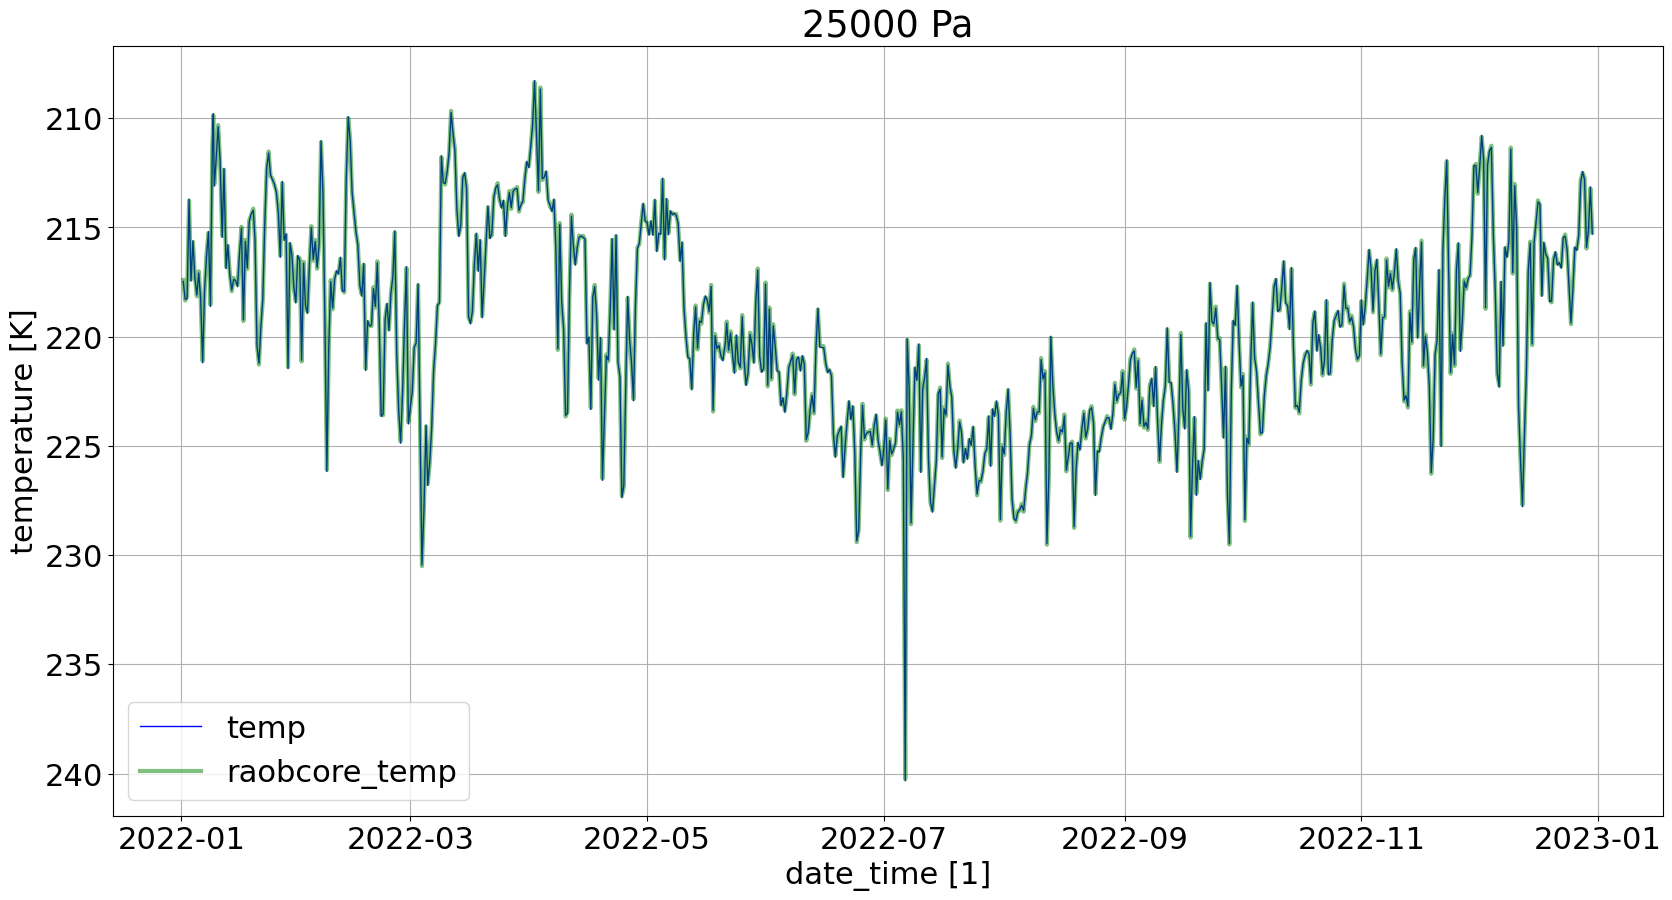

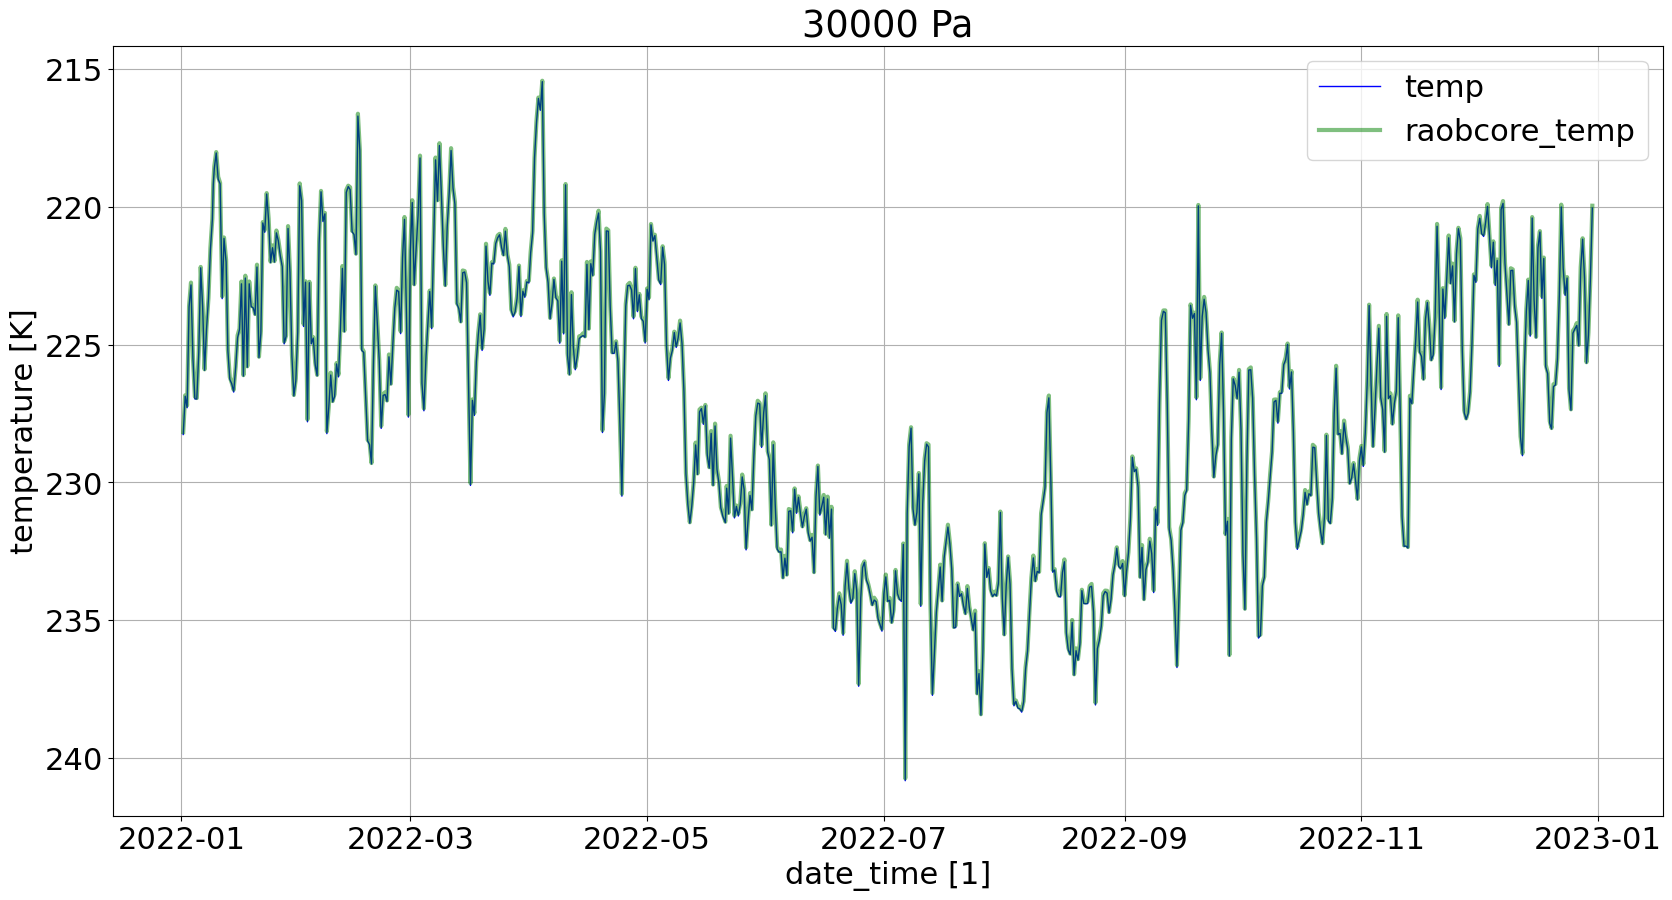

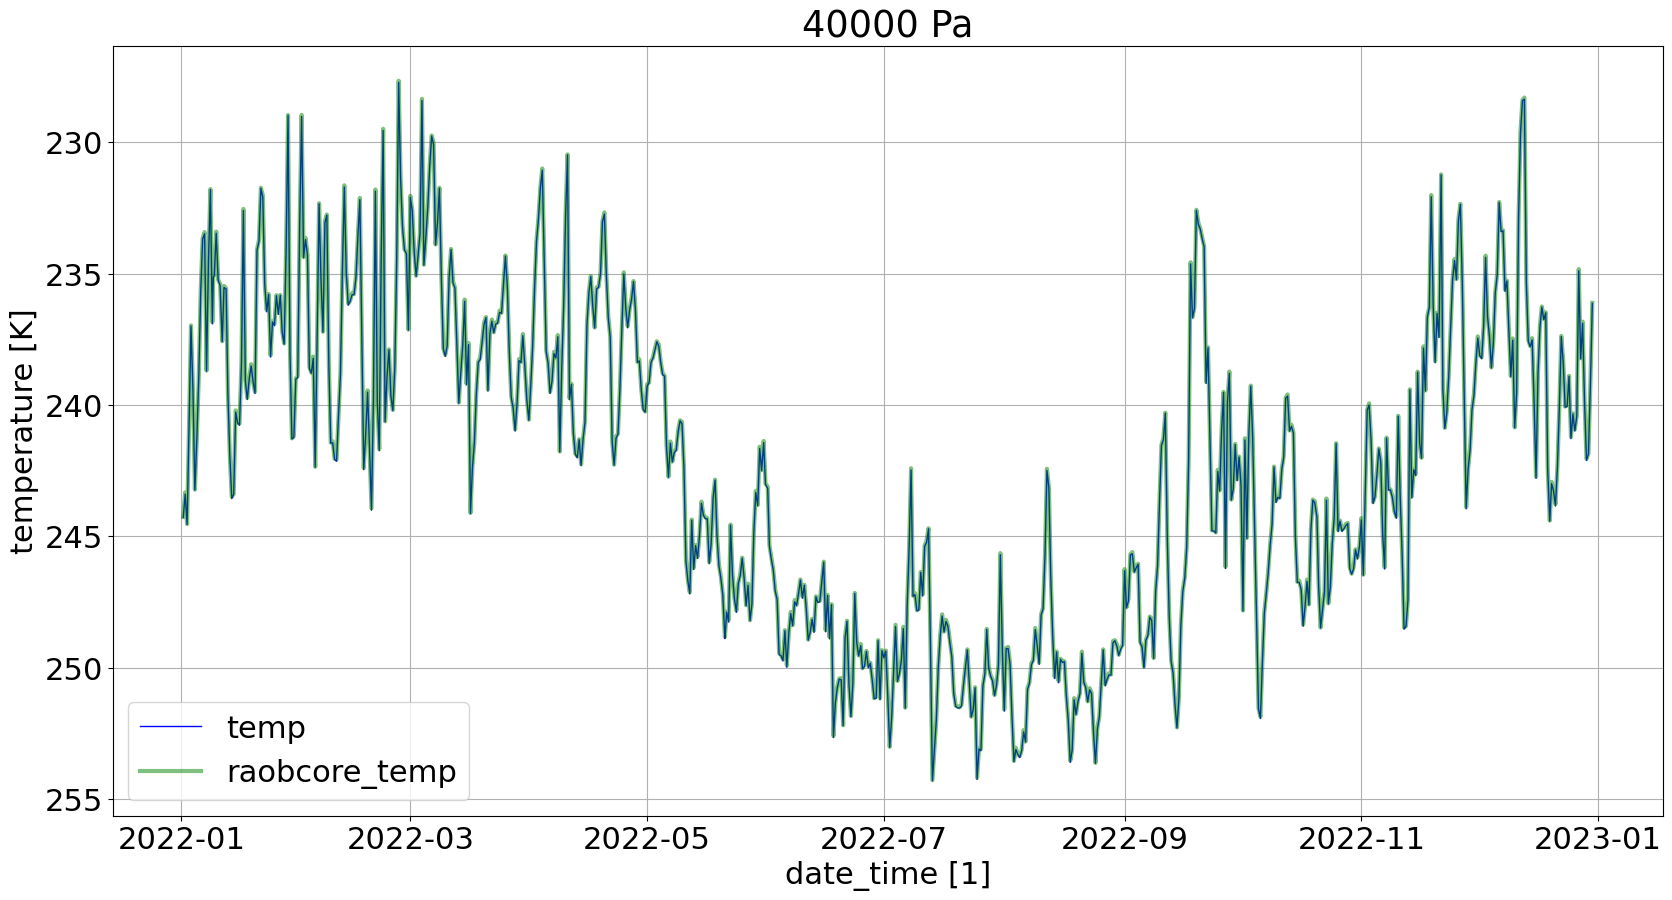

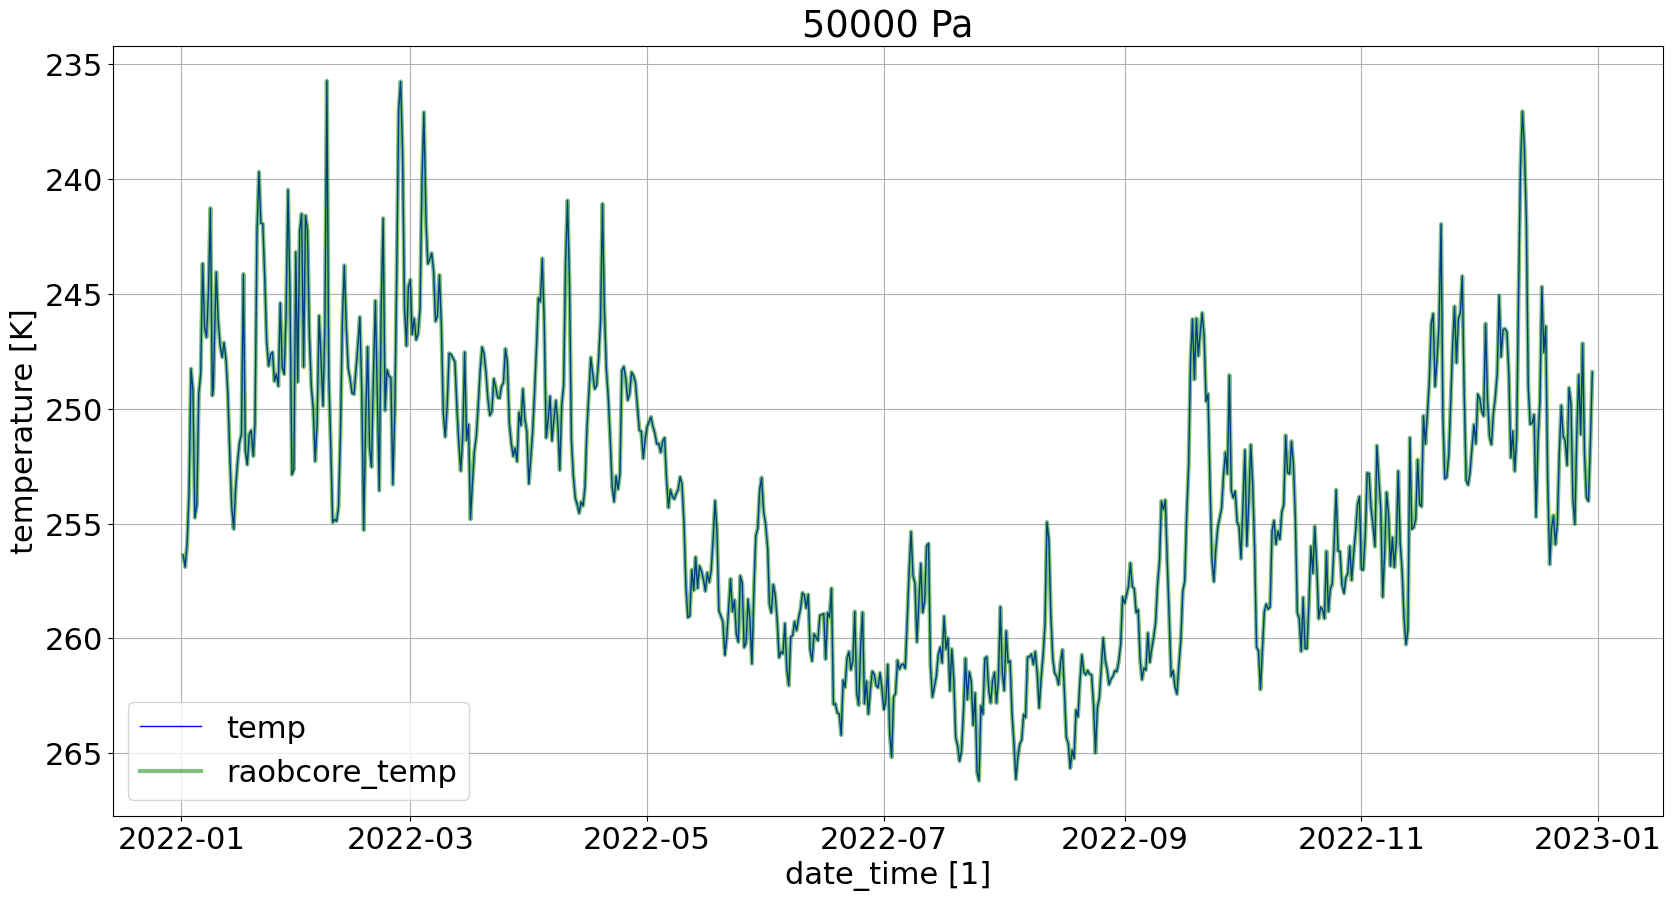

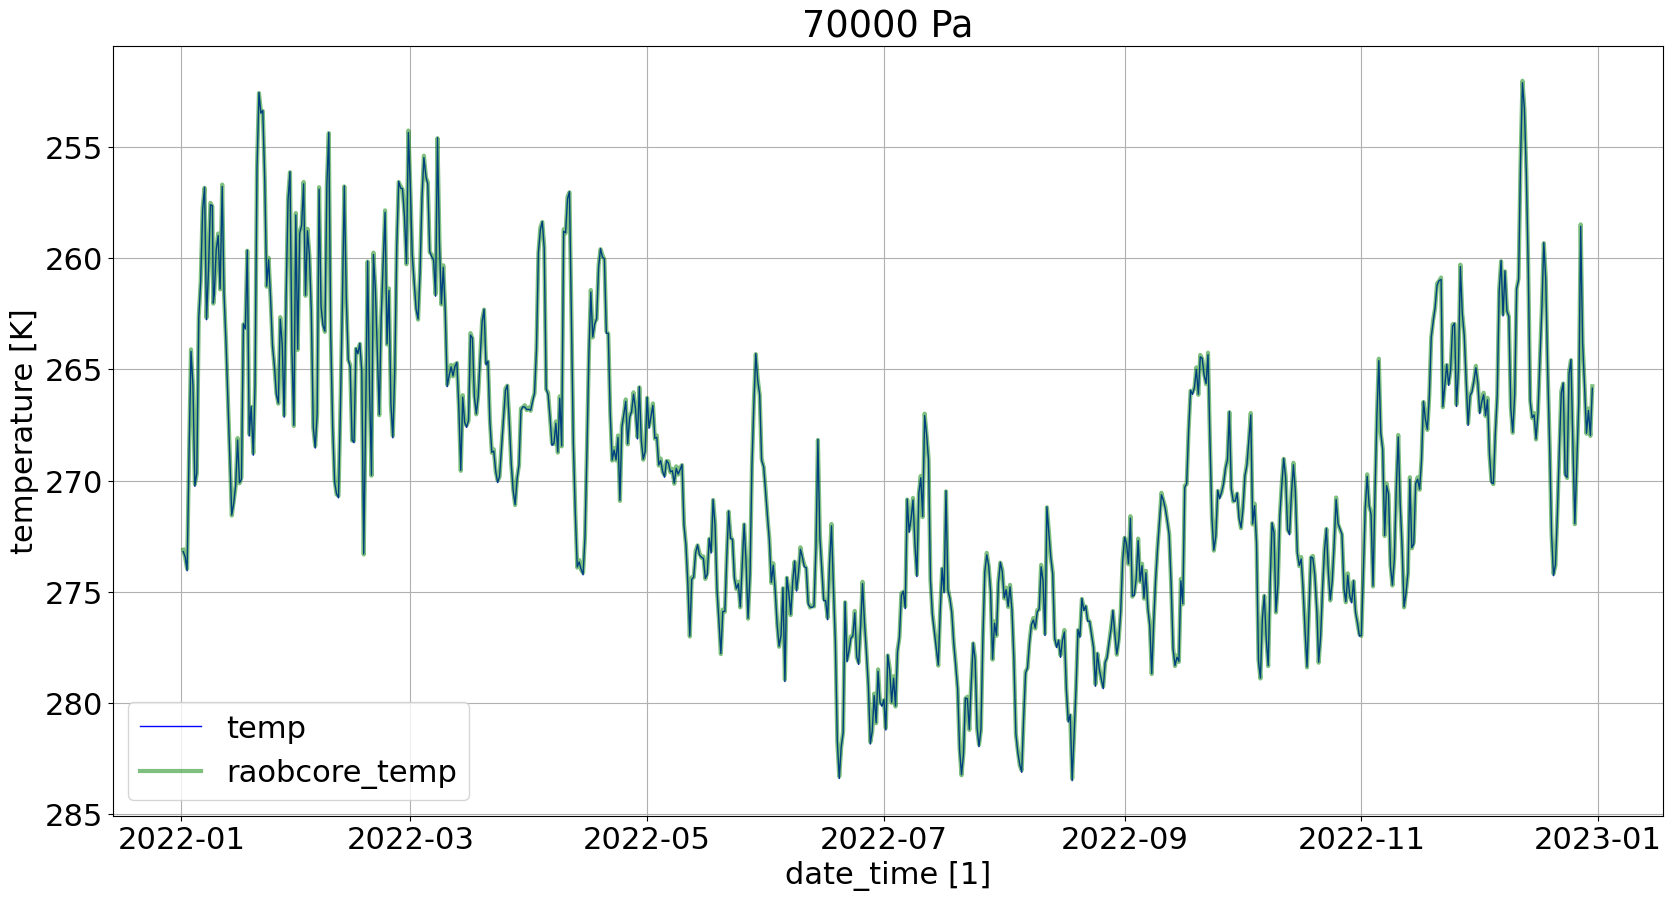

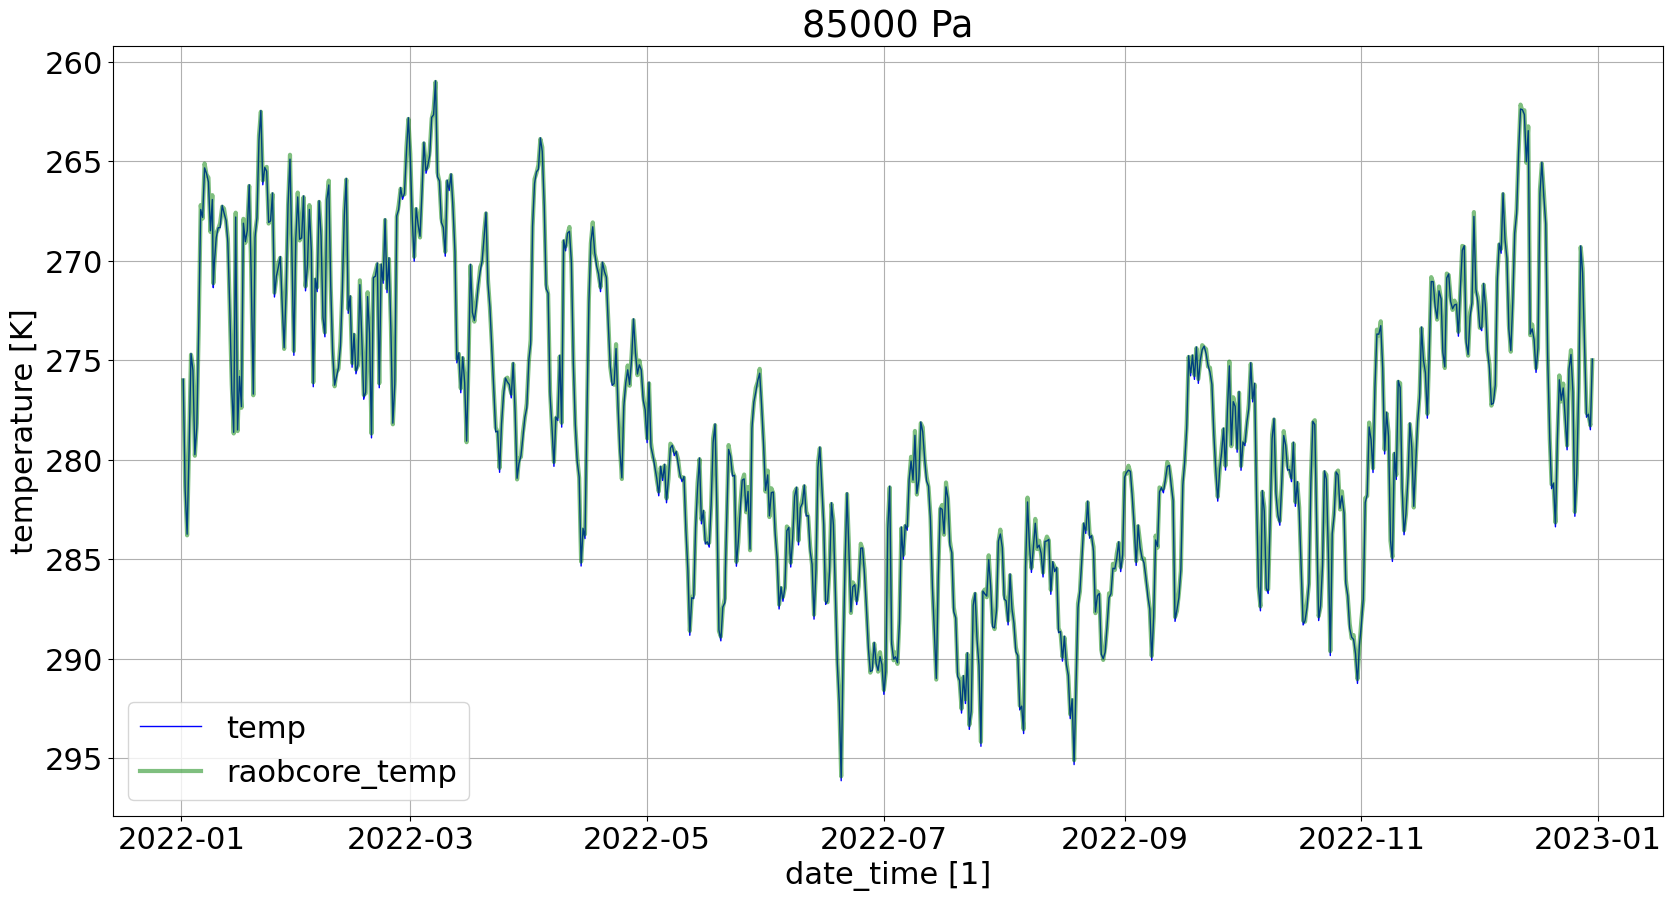

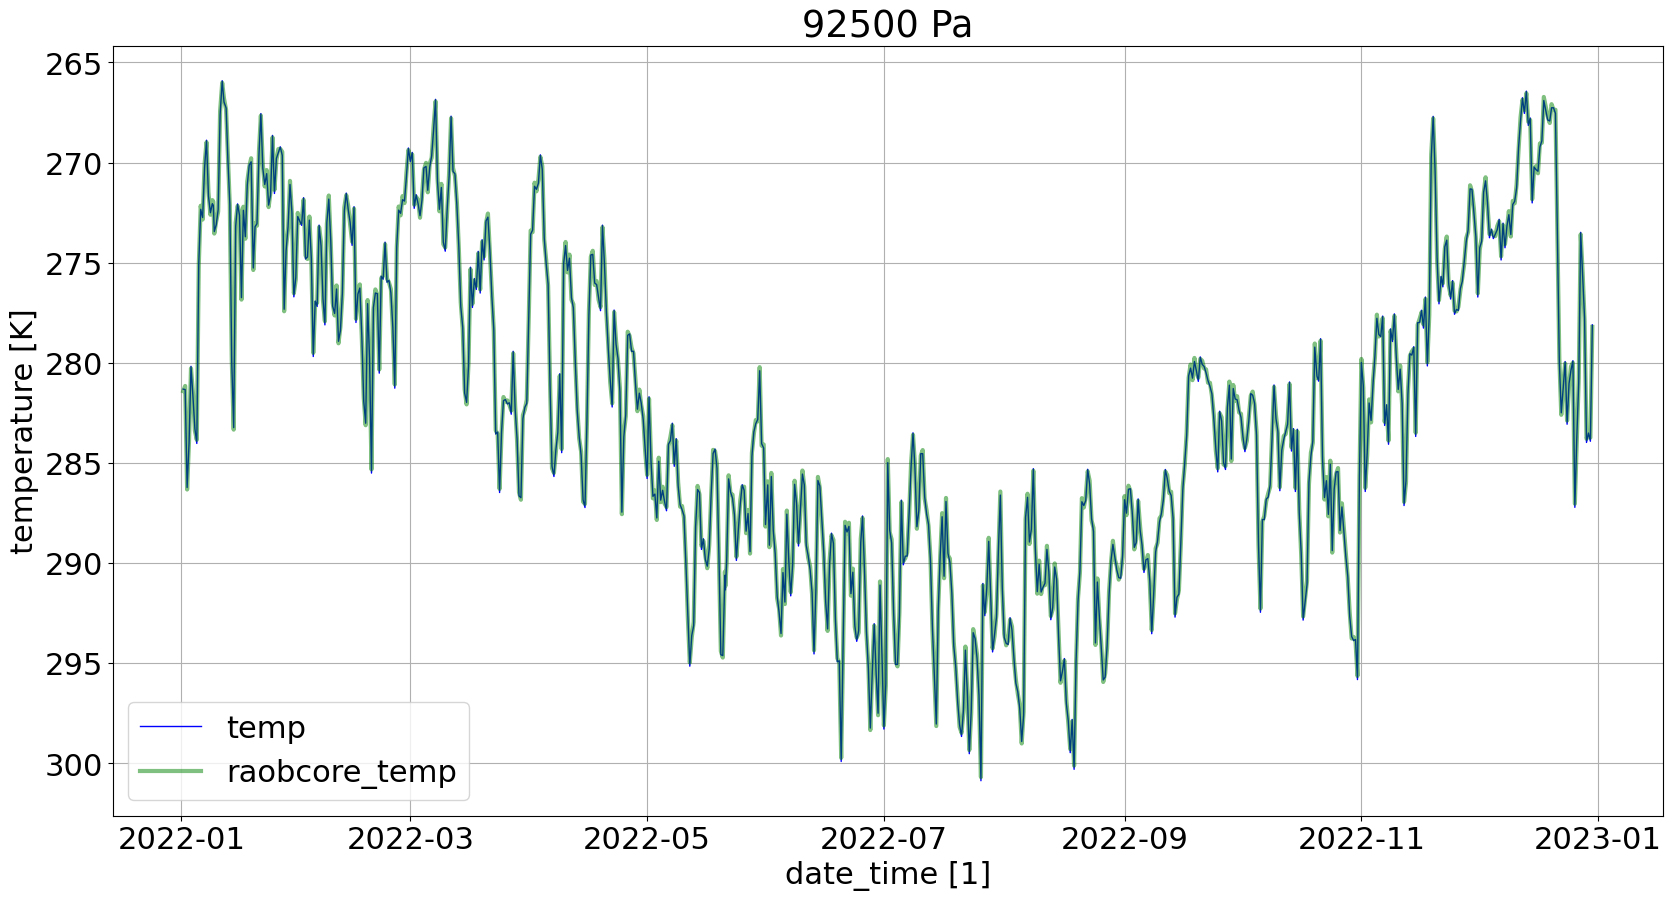

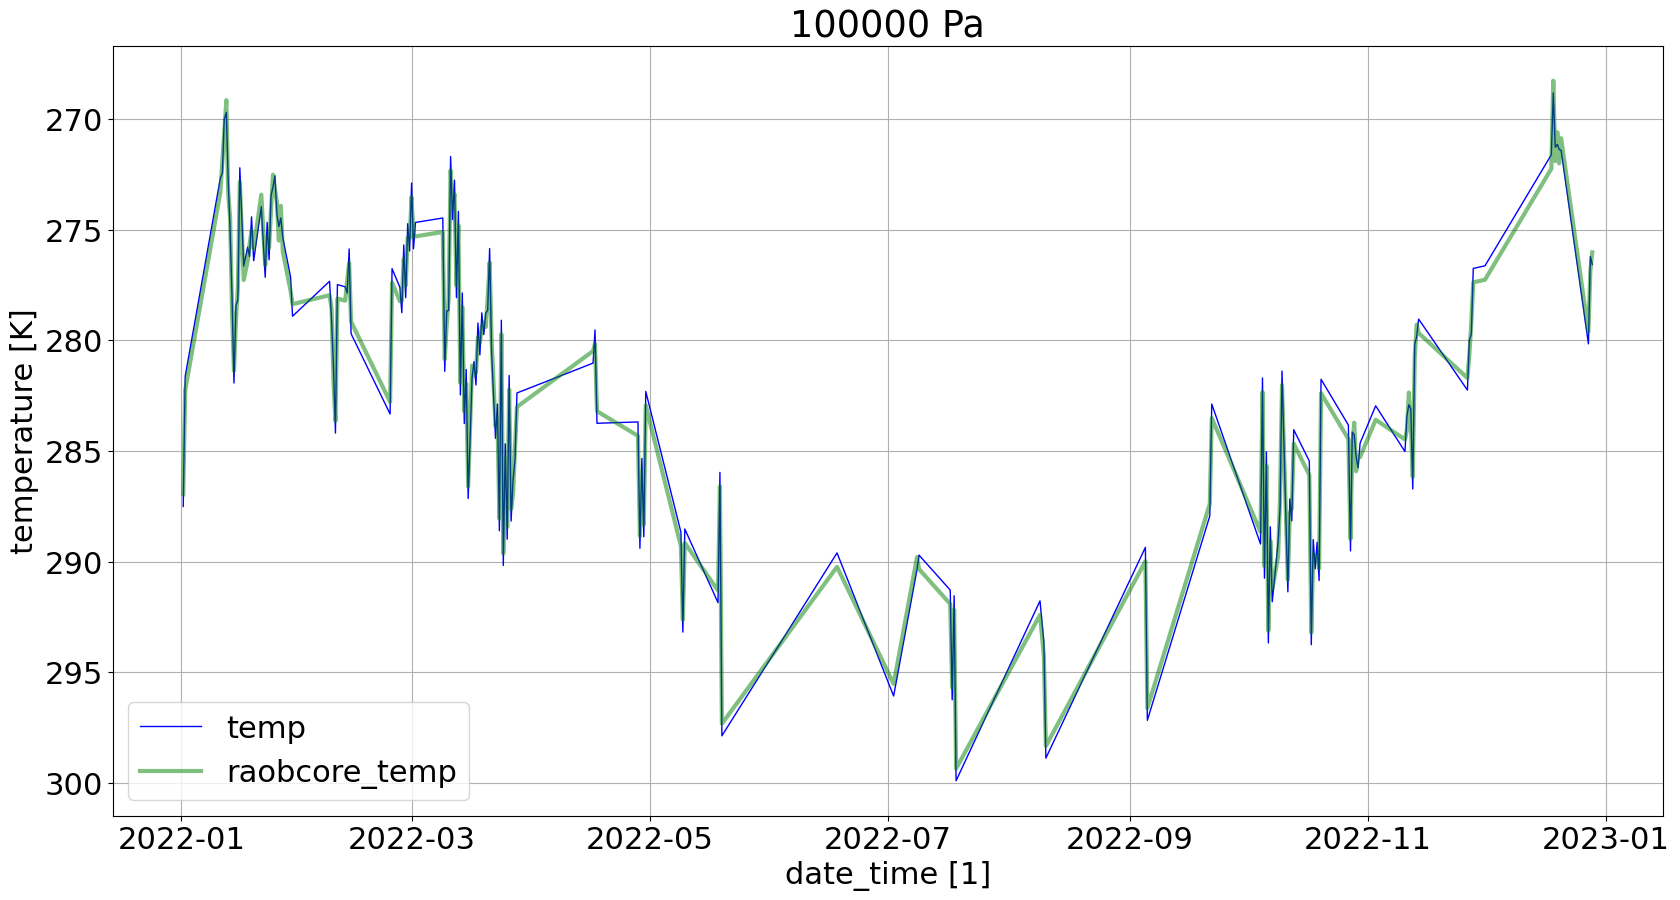

In [12]:
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*11035*_CEUAS_merged_v1.nc')[0]
dt_from = datetime_to_seconds(np.datetime64('2022-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    idx_d = {}
    # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
    var_d = {'air_temperature':'126'}
    for i in var_d:
        idx_d[i] = file['recordindices'][var_d[i]][idx]

    masks = {}
    for i in idx_d:
        masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
        masks[i] = np.isin(masks[i],plevs)
        masks[i] = np.isfinite(masks[i])

    mask = masks['air_temperature']
    t_idx = idx_d['air_temperature']
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
    df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
df_old = pd.DataFrame.from_dict(df_dict)
for i in plevs:
    df_plev = df_old[df_old.z_coordinate == i]
    plt.plot(df_plev.date_time, df_plev.air_temperature, color = 'blue', linewidth = 1, alpha = 1, label='temp')
    plt.plot(df_plev.date_time, (df_plev.air_temperature - df_plev.RAOBCORE_bias_estimate), color = 'green', linewidth = 3, alpha = 0.5, label='raobcore_temp')

    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])

    plt.title(str(i) + ' Pa')
    plt.ylabel('temperature [K]')
    plt.xlabel('date_time [1]')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

RAOBCORE_bias_estimate  RASE_bias_estimate  RICH_bias_estimate  \
0                        NaN                 NaN                 NaN   
1                        NaN                 NaN                 NaN   
2                        NaN                 NaN                 NaN   
3                        NaN                 NaN                 NaN   
4                        NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
2528                0.498339                 NaN            0.498339   
2529                0.500930                 NaN            0.500930   
2530                0.506114                 NaN            0.506114   
2531                0.506978                 NaN            0.506978   
2532                     NaN                 NaN                 NaN   

      RISE_bias_estimate        lat       lon  obs     plev        report_id  \
0                    NaN  48.248871  16.35759    0    380.0  100000000118586   
1                    NaN  48.248871  16.35759    0    390.0  100000000118586   
2                    NaN  48.248871  16.35759    0    400.0  100000000118586   
3                    NaN  48.248871  16.35759    0    410.0  100000000118586   
4                    NaN  48.248871  16.35759    0    420.0  100000000118586   
...                  ...        ...       ...  ...      ...              ...   
2528                 NaN  48.248871  16.35759    0  99440.0  100000000118586   
2529                 NaN  48.248871  16.35759    0  99470.0  100000000118586   
2530                 NaN  48.248871  16.35759    0  99530.0  100000000118586   
2531                 NaN  48.248871  16.35759    0  99540.0  100000000118586   
2532                 NaN  48.248871  16.35759    0  99900.0  100000000118586   

                     station_id          ta                time  
0     WIEN/HOHE WARTE (11035-1)  231.889999 2022-12-31 11:30:23  
1     WIEN/HOHE WARTE (11035-1)  231.759995 2022-12-31 11:30:23  
2     WIEN/HOHE WARTE (11035-1)  232.369995 2022-12-31 11:30:23  
3     WIEN/HOHE WARTE (11035-1)  232.880005 2022-12-31 11:30:23  
4     WIEN/HOHE WARTE (11035-1)  232.059998 2022-12-31 11:30:23  
...                         ...         ...                 ...  
2528  WIEN/HOHE WARTE (11035-1)  279.660004 2022-12-31 11:30:23  
2529  WIEN/HOHE WARTE (11035-1)  279.799988 2022-12-31 11:30:23  
2530  WIEN/HOHE WARTE (11035-1)  279.920013 2022-12-31 11:30:23  
2531  WIEN/HOHE WARTE (11035-1)  280.049988 2022-12-31 11:30:23  
2532  WIEN/HOHE WARTE (11035-1)  280.350006 2022-12-31 11:30:23  

[2533 rows x 12 columns]

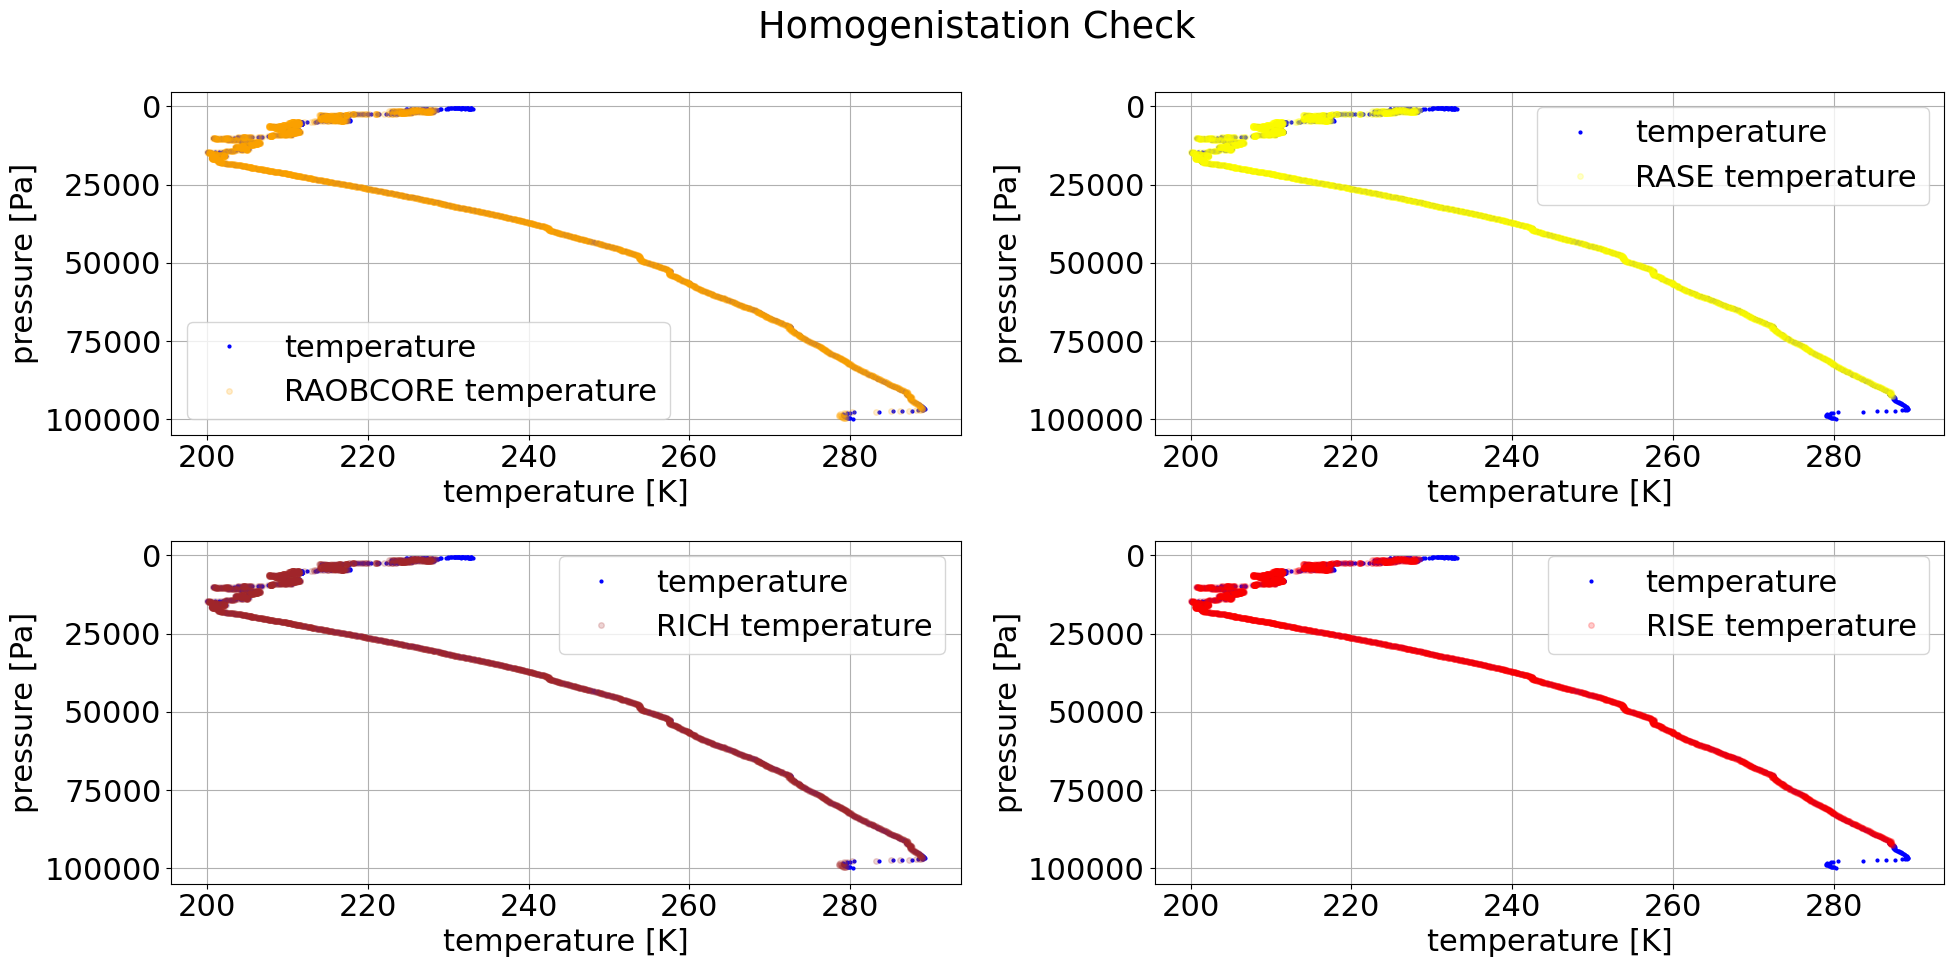

In [13]:
rq = {'variable': ['air_temperature'], 'statid': '11035', 'date': '20221231-20221231','optional': ['RAOBCORE_bias_estimate', 'RISE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate',], 'format': 'nc'} # 0-20999-0-ZEKG

df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

df = df.to_dataframe()
display(df)
# del df

fig, axs = plt.subplots(2,2)
fig.suptitle('Homogenistation Check')

axs[0][0].plot(df.ta, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='temperature')
axs[0][0].plot((df.ta - df.RAOBCORE_bias_estimate), df.plev, 'o', color = 'orange',markersize = 4, alpha = 0.2, label='RAOBCORE temperature')

axs[0][1].plot(df.ta, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='temperature')
axs[0][1].plot((df.ta - df.RASE_bias_estimate), df.plev, 'o', color = 'yellow',markersize = 4, alpha = 0.2, label='RASE temperature')

axs[1][0].plot(df.ta, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='temperature')
axs[1][0].plot((df.ta - df.RICH_bias_estimate), df.plev, 'o', color = 'brown',markersize = 4, alpha = 0.2, label='RICH temperature')

axs[1][1].plot(df.ta, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='temperature')
axs[1][1].plot((df.ta - df.RISE_bias_estimate), df.plev, 'o', color = 'red',markersize = 4, alpha = 0.2, label='RISE temperature')

for ax in axs.flat:
    ax.set(xlabel='temperature [K]', ylabel='pressure [Pa]', ylim=ax.get_ylim()[::-1])
    ax.set_title(None)
    ax.grid()
    ax.legend()

fig.tight_layout()
fig.show()


humidity_bias_estimate       hur        lat       lon  obs     plev  \
0                        NaN  0.010581  48.248871  16.35759    0    380.0   
1                        NaN  0.010577  48.248871  16.35759    0    390.0   
2                        NaN  0.010573  48.248871  16.35759    0    400.0   
3                        NaN  0.010565  48.248871  16.35759    0    410.0   
4                        NaN  0.010572  48.248871  16.35759    0    420.0   
...                      ...       ...        ...       ...  ...      ...   
2528                     NaN  0.792027  48.248871  16.35759    0  99440.0   
2529                     NaN  0.788326  48.248871  16.35759    0  99470.0   
2530                     NaN  0.784618  48.248871  16.35759    0  99530.0   
2531                     NaN  0.782605  48.248871  16.35759    0  99540.0   
2532                     NaN  0.802033  48.248871  16.35759    0  99900.0   

            report_id                 station_id                time  
0     100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
1     100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
2     100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
3     100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
4     100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
...               ...                        ...                 ...  
2528  100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
2529  100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
2530  100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
2531  100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  
2532  100000000118586  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  

[2533 rows x 9 columns]

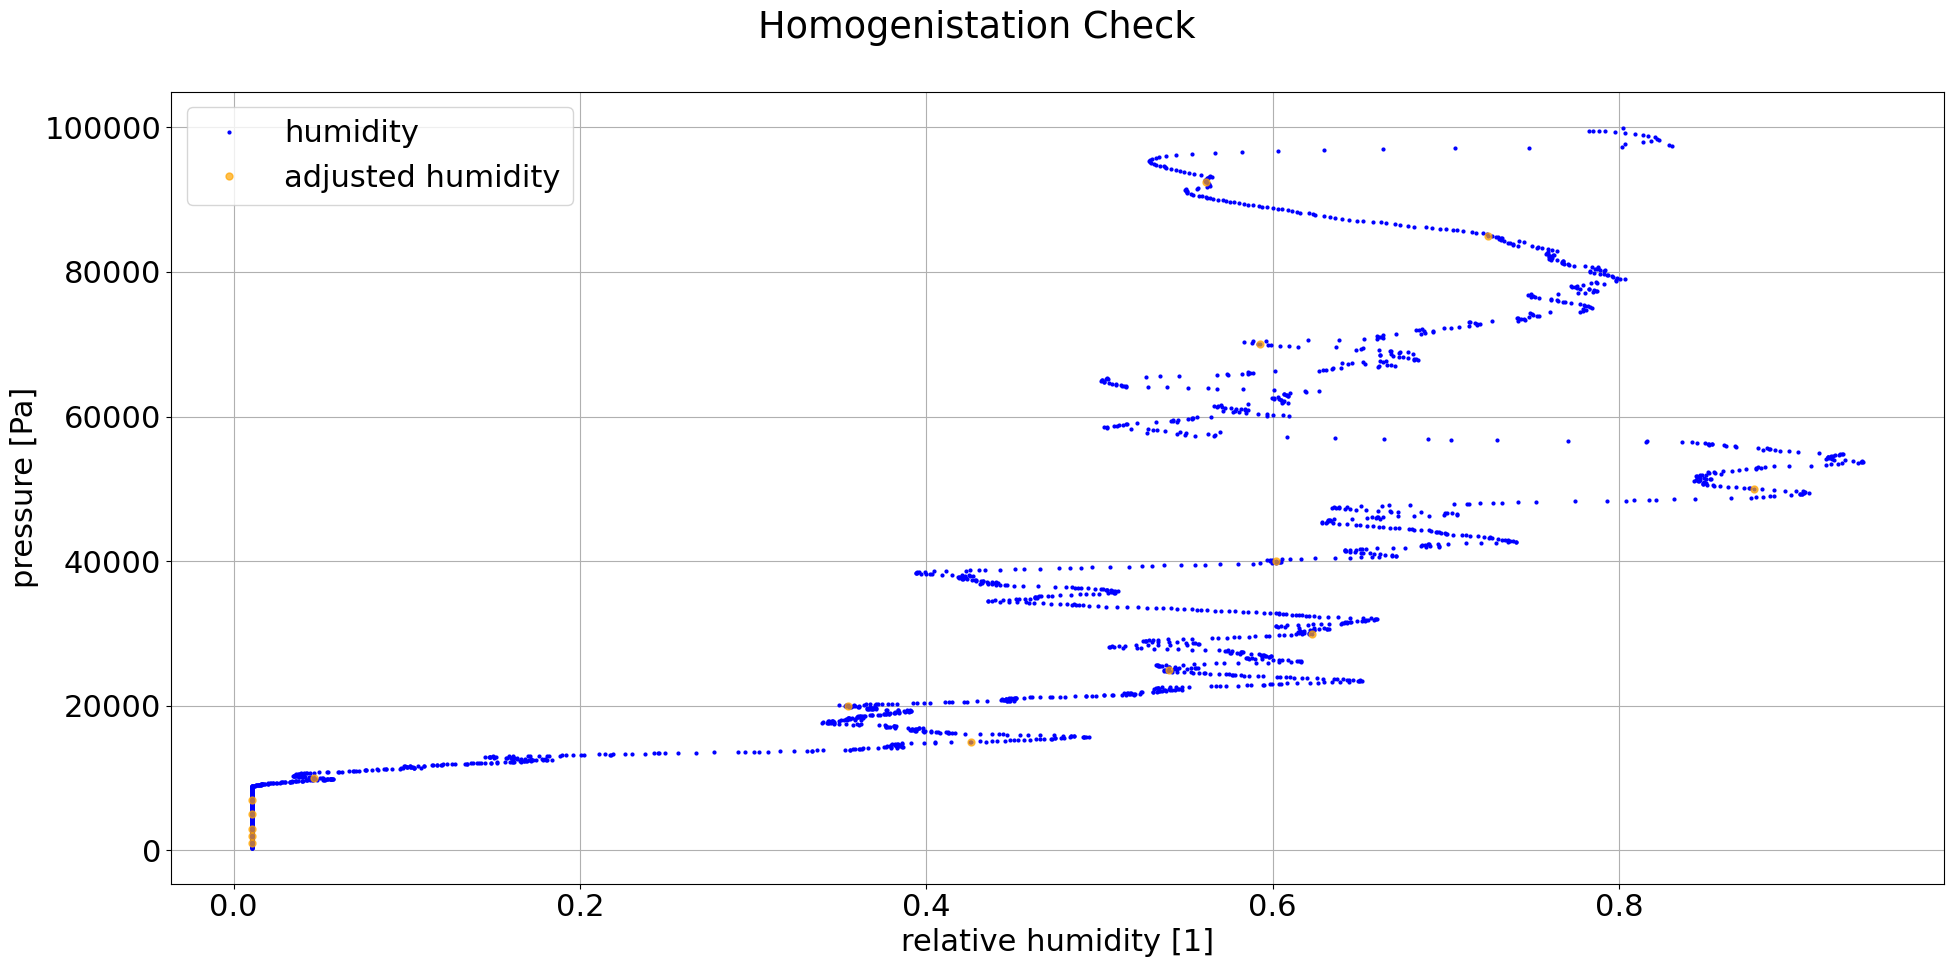

In [14]:
rq = {'variable': ['relative_humidity'], 'statid': '11035', 'date': '20221231-20221231','optional': ['humidity_bias_estimate',], 'format': 'nc'} # 0-20999-0-ZEKG

df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

df = df.to_dataframe()
display(df)
# del df

fig, axs = plt.subplots(1)
fig.suptitle('Homogenistation Check')

axs.plot(df.hur, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='humidity')
axs.plot((df.hur - df.humidity_bias_estimate), df.plev, 'o', color = 'orange',markersize = 5, alpha = 0.7, label='adjusted humidity')
axs.set(xlabel='relative humidity [1]', ylabel='pressure [Pa]', ylim=ax.get_ylim()[::-1])
axs.set_title(None)
axs.grid()
axs.legend()

fig.tight_layout()
fig.show()


lat       lon  obs     plev        report_id  \
0     48.248871  16.35759    0    380.0  100000000118586   
1     48.248871  16.35759    0    390.0  100000000118586   
2     48.248871  16.35759    0    400.0  100000000118586   
3     48.248871  16.35759    0    410.0  100000000118586   
4     48.248871  16.35759    0    420.0  100000000118586   
...         ...       ...  ...      ...              ...   
2528  48.248871  16.35759    0  99440.0  100000000118586   
2529  48.248871  16.35759    0  99470.0  100000000118586   
2530  48.248871  16.35759    0  99530.0  100000000118586   
2531  48.248871  16.35759    0  99540.0  100000000118586   
2532  48.248871  16.35759    0  99900.0  100000000118586   

                     station_id                time         ua  \
0     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  74.686432   
1     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  86.784409   
2     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  84.411598   
3     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  84.962601   
4     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23  84.384399   
...                         ...                 ...        ...   
2528  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   1.057515   
2529  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   1.098807   
2530  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   1.016842   
2531  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   1.016842   
2532  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   0.976828   

      wind_bias_estimate  
0          -2.235010e-06  
1           1.196655e-06  
2          -3.474570e-06  
3          -7.481032e-08  
4          -8.002264e-07  
...                  ...  
2528        8.114066e-09  
2529       -2.301110e-08  
2530       -3.241820e-08  
2531       -3.241820e-08  
2532        1.260363e-08  

[2533 rows x 9 columns]

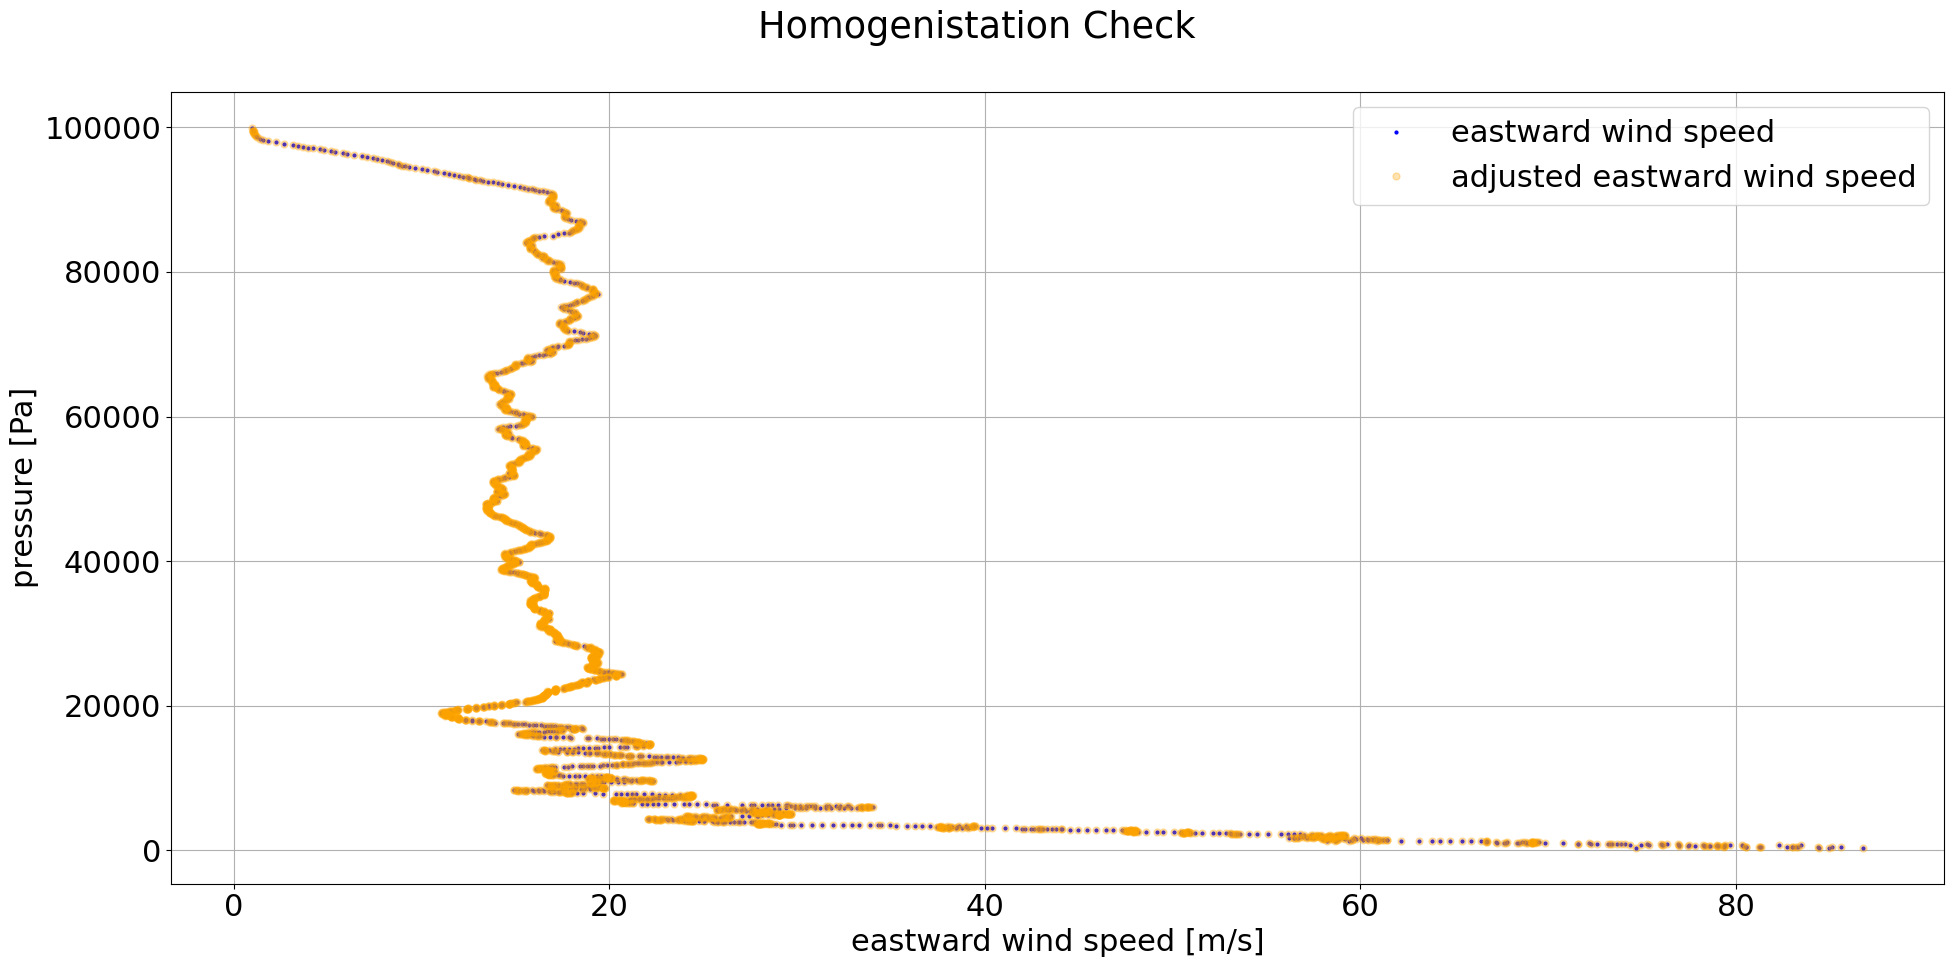

In [15]:
rq = {'variable': ['eastward_wind_speed'], 'statid': '11035', 'date': '20221231-20221231','optional': ['wind_bias_estimate',], 'format': 'nc'} # 0-20999-0-ZEKG

df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

df = df.to_dataframe()
display(df)
# del df

fig, axs = plt.subplots(1)
fig.suptitle('Homogenistation Check')

axs.plot(df.ua, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='eastward wind speed')
axs.plot((df.ua - df.wind_bias_estimate), df.plev, 'o', color = 'orange',markersize = 5, alpha = 0.3, label='adjusted eastward wind speed')
axs.set(xlabel='eastward wind speed [m/s]', ylabel='pressure [Pa]', ylim=ax.get_ylim()[::-1])
axs.set_title(None)
axs.grid()
axs.legend()

fig.tight_layout()
fig.show()


lat       lon  obs     plev        report_id  \
0     48.248871  16.35759    0    380.0  100000000118586   
1     48.248871  16.35759    0    390.0  100000000118586   
2     48.248871  16.35759    0    400.0  100000000118586   
3     48.248871  16.35759    0    410.0  100000000118586   
4     48.248871  16.35759    0    420.0  100000000118586   
...         ...       ...  ...      ...              ...   
2528  48.248871  16.35759    0  99440.0  100000000118586   
2529  48.248871  16.35759    0  99470.0  100000000118586   
2530  48.248871  16.35759    0  99530.0  100000000118586   
2531  48.248871  16.35759    0  99540.0  100000000118586   
2532  48.248871  16.35759    0  99900.0  100000000118586   

                     station_id                time         va  \
0     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23 -28.669436   
1     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23 -35.063179   
2     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23 -37.582466   
3     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23 -36.064484   
4     WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23 -30.713409   
...                         ...                 ...        ...   
2528  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   2.375218   
2529  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   2.356400   
2530  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   2.283864   
2531  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   2.283864   
2532  WIEN/HOHE WARTE (11035-1) 2022-12-31 11:30:23   2.301262   

      wind_bias_estimate  
0           4.625254e-07  
1           1.370709e-06  
2           3.153465e-07  
3           7.093986e-07  
4           4.905796e-07  
...                  ...  
2528        2.963923e-08  
2529        4.684958e-08  
2530       -5.841765e-08  
2531       -5.841765e-08  
2532       -1.231017e-08  

[2533 rows x 9 columns]

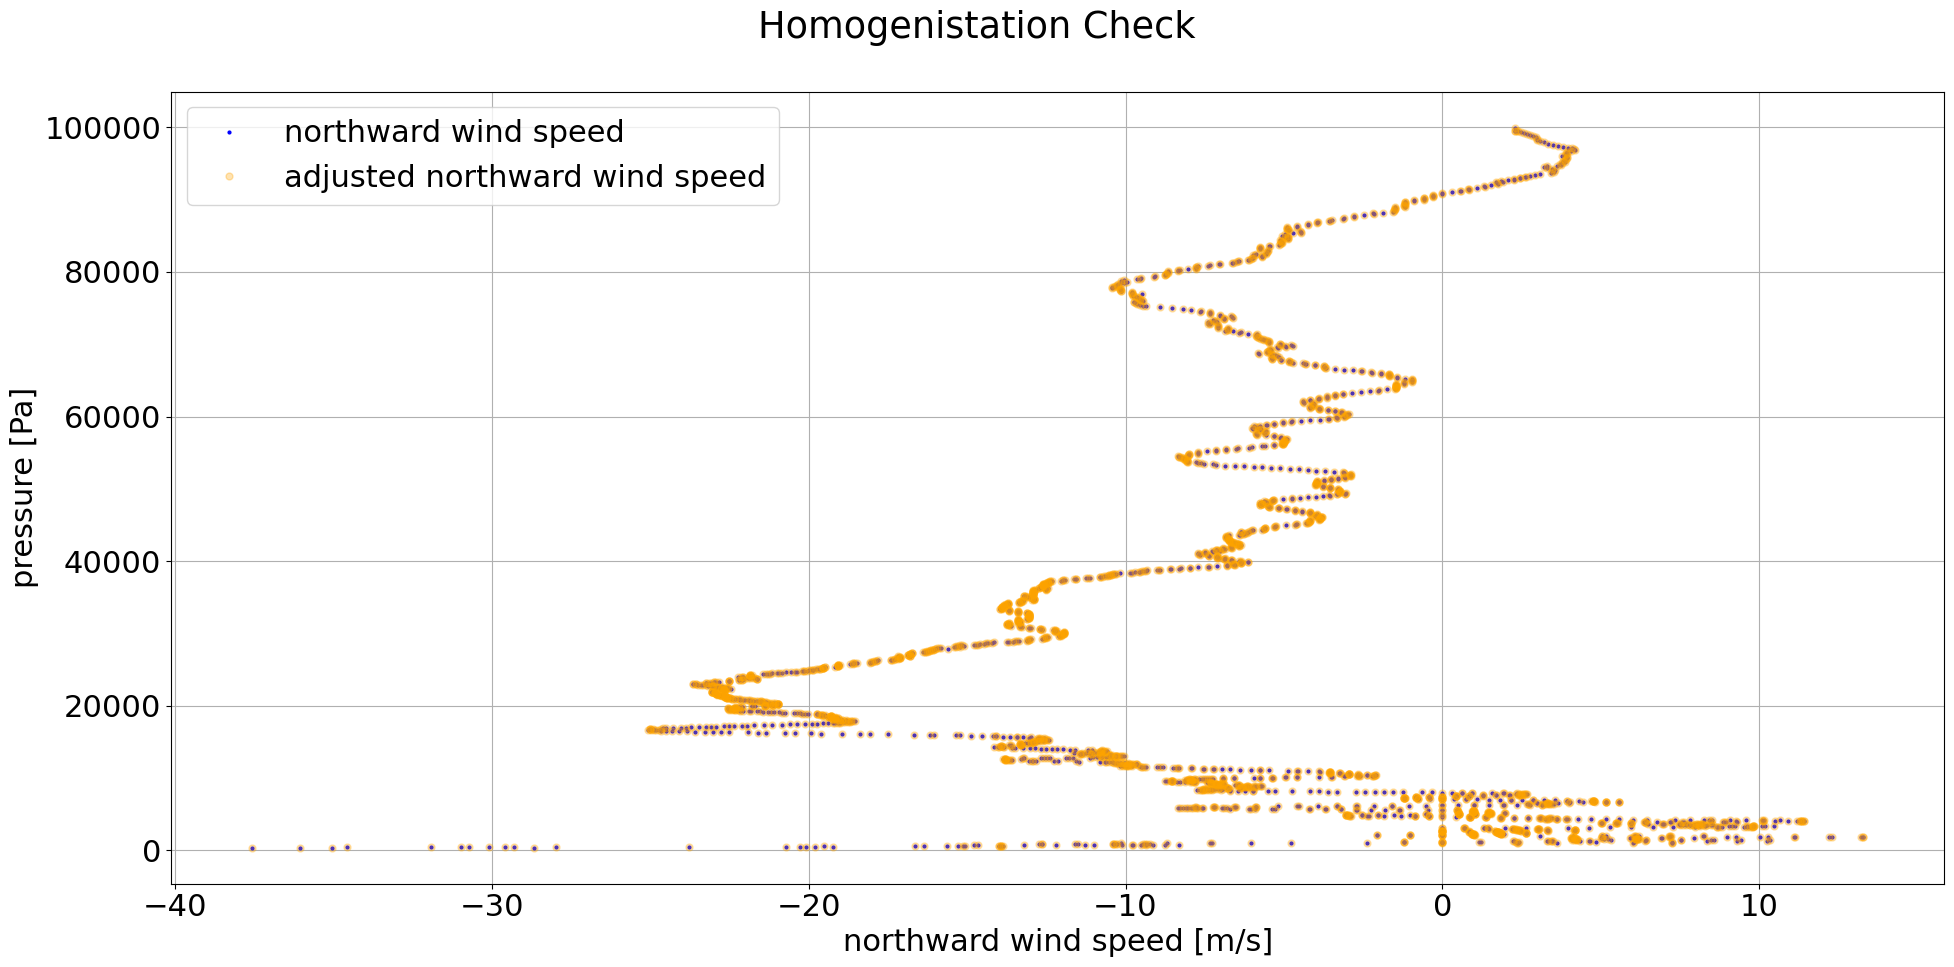

In [18]:
rq = {'variable': ['northward_wind_speed'], 'statid': '11035', 'date': '20221231-20221231','optional': ['wind_bias_estimate',], 'format': 'nc'} # 0-20999-0-ZEKG

df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

df = df.to_dataframe()
display(df)
# del df

fig, axs = plt.subplots(1)
fig.suptitle('Homogenistation Check')

axs.plot(df.va, df.plev, 'o', color = 'blue', markersize = 2, alpha = 1, label='northward wind speed')
axs.plot((df.va - df.wind_bias_estimate), df.plev, 'o', color = 'orange',markersize = 5, alpha = 0.3, label='adjusted northward wind speed')
axs.set(xlabel='northward wind speed [m/s]', ylabel='pressure [Pa]', ylim=ax.get_ylim()[::-1])
axs.set_title(None)
axs.grid()
axs.legend()

fig.tight_layout()
fig.show()


In [3]:
def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
           grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
           data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
    """ Plot stations on a map

    Args:
        lon (np.array, list): Longitudes
        lat (np.array, list): Latidutes
        labels (np.array, list): Labels
        values (np.array, list): Values for scatterplot
        markersize (int): markersize
        ocean (bool): plot ocean ?
        land (bool): plot land ?
        coastlines (bool): plot coastlines ?
        rivers (bool): plot river ?
        grid (bool): plot gridlines ?
        posneg (bool): different markers for positive and negative
        extent (str): neither (default), both, min, max
        lloffset (float): label offset
        showcost (bool): Estimate Cost function and add to title
        clabel (str): Colorbar Label
        cbars (dict): Colorbar Options
        colorlevels (list, str): scatterplot colorlevels
        data (xr.DataArray): Data
        vmin (float): minimum value
        vmax (float): maximum value
        dropna (bool): Remove missing values?
        figure (plt.figure): figure handle
        gridspecs (dict): gridspec options for figure
        **kwargs:

    Returns:
        plt.axes
    """
    import numpy as np
    import cartopy as cpy
    from matplotlib.colors import BoundaryNorm
    import matplotlib.pyplot as plt
#     from ._helpers import cost, plot_arange as pa, plot_levels as pl

    if data is not None:
        lon = data[lon]
        lat = data[lat]
        values = data

    lon = np.asarray(lon)
    lat = np.asarray(lat)

    if lon.size != lat.size:
        raise ValueError("Lon and Lat need same size")

    if values is not None:
        values = np.asarray(values, dtype=float)
        nn = np.size(values)
        if lon.size != lat.size or lon.size != values.size:
            raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

        if vmin is not None:
            idx = values < vmin
            values[idx] = np.nan
            print("vmin", idx.sum(), nn)

        if vmax is not None:
            idx = values > vmax
            values[idx] = np.nan
            print("vmax", idx.sum(), nn)

        if dropna:
            idx = np.isfinite(values)
            values = values[idx]
            lon = lon[idx]
            lat = lat[idx]
            print("NA", nn - idx.sum(), nn)

    projection = kwargs.get('projection', cpy.crs.PlateCarree())
    if figure is None:
        ax = plt.axes(projection=projection)
    else:
        ax = figure.add_subplot(gridspecs, projection=projection)

    if ocean:
        ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

    if land:
        ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

    if coastlines:
        ax.coastlines()

    if rivers:
        ax.add_feature(cpy.feature.LAKES, zorder=0)
        ax.add_feature(cpy.feature.RIVERS, zorder=1)

    if labels is not None:
        labels = np.asarray(labels)

    if values is None:
        ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
                   edgecolor='k')  # ontop
    else:
        if posneg:
            kwargs['marker'] = np.where(values < 0, 'd', 'o')

        cmap = plt.get_cmap(kwargs.pop('cmap', None))
        norm = None
        if colorlevels is not None:
            if isinstance(colorlevels, str):
                colorlevels = eval(colorlevels)  # plot_levels, plot_arange

            norm = BoundaryNorm(colorlevels, cmap.N)
        idx = np.isfinite(values)
        cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
                        transform=cpy.crs.PlateCarree(),
                        zorder=10,
                        cmap=cmap,
                        edgecolor='k',
                        alpha=showalpha,
                        marker=kwargs.get('marker', 'o'),
                        norm=norm)

        cbars['fraction'] = cbars.get('fraction', 0.01)
        cbars['aspect'] = cbars.get('aspect', 50)
        cbars['shrink'] = cbars.get('shrink', 0.8)
        cbars['extend'] = cbars.get('extend', 'both')
        cb = plt.colorbar(cs, ax=ax, **cbars)

        if clabel is not None:
            cb.set_label(clabel)

        if showcost:
            tcost = cost(lon, lat, values)

        if np.isfinite(values).sum() != np.size(values):
            itx = ~np.isfinite(values)
            ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
                       edgecolor='k',alpha=showalpha)

    if labels is not None:
        if not hasattr(lloffset, '__iter__'):
            lloffset = [lloffset] * len(labels)

        for i, j, l, k in zip(lon, lat, labels, lloffset):
            ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
                    transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
                    clip_on=True)

    if grid:
        try:
            gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
                              linewidth=0.5, linestyle='--', color='k')
            gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
            gl.xlabels_top = False
            gl.ylabels_right = False
        except:
            ax.gridlines(draw_labels=False)

    if values is not None:
        nn = np.sum(np.isfinite(values))
        title = showtitle
        # COST Summary
        if showcost:
            tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
            title += ' Cost: %5.2f' % tscost
    else:
        title = 'Stations # %d' % np.size(lon)

    ax.set_title(kwargs.get('title', '') + ' ' + title)

    if 'xlabel' in kwargs.keys():
        ax.set_xlabel(kwargs.get('xlabel'))

    if 'ylabel' in kwargs.keys():
        ax.set_ylabel(kwargs.get('ylabel'))

    if extent is not None:
        ax.set_extent(extent, crs=cpy.crs.PlateCarree())

    return ax

In [7]:
plev = 10000
lat_list = []
lon_list = []
lable_list = []
value_list = []
value_adjusted_list = []
mean_noon_adjustment_list = []
mean_midnight_adjustment_list = []


dt_from = datetime_to_seconds(np.datetime64('2022-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

for stat in glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*_CEUAS_merged_v1.nc')[0:2000]:
    try:
        df_dict = {}
        print(stat)
        with h5py.File(stat, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            plevs = [plev]
            idx_d = {}
            # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
            var_d = {'air_temperature':'126'}
            for i in var_d:
                idx_d[i] = file['recordindices'][var_d[i]][idx]

            masks = {}
            for i in idx_d:
                masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
                masks[i] = np.isin(masks[i],plevs)
                masks[i] = np.isfinite(masks[i])

            mask = masks['air_temperature']
            t_idx = idx_d['air_temperature']
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
            df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            lat_list.append(file['observations_table']['latitude'][-1])
            lon_list.append(file['observations_table']['longitude'][-1])

        lable_list.append(stat.split('/')[-2])
        df = pd.DataFrame.from_dict(df_dict)
        df = df[np.isin(df.z_coordinate, plevs)]
        df.date_time = pd.to_datetime(df.date_time)
        day_night_diff = []
        day_night_diff_adjusted = []
        noon_adjustments = []
        midnight_adjustments = []
        for j in df.date_time.drop_duplicates():
            day_df = df[df.date_time.dt.date == j.date()]
            noon_df = day_df[np.isin(day_df.date_time.dt.hour, [11,12,13])]
            midnight_df = day_df[np.isin(day_df.date_time.dt.hour, [23,0,1])]
            if np.logical_and(len(midnight_df) > 0, len(noon_df) > 0):
                day_night_diff.append(noon_df.air_temperature.iloc[0] - midnight_df.air_temperature.iloc[0])
                day_night_diff_adjusted.append((noon_df.air_temperature.iloc[0]-noon_df.RAOBCORE_bias_estimate.iloc[0]) - (midnight_df.air_temperature.iloc[0]-midnight_df.RAOBCORE_bias_estimate.iloc[0]))
                noon_adjustments.append(float(noon_df.RAOBCORE_bias_estimate.iloc[0]))
                midnight_adjustments.append(float(midnight_df.RAOBCORE_bias_estimate.iloc[0]))
        value_list.append(np.nanmean(day_night_diff))
        value_adjusted_list.append(np.nanmean(day_night_diff_adjusted))
        mean_noon_adjustment_list.append(np.nanmean(noon_adjustments))
        mean_midnight_adjustment_list.append(np.nanmean(midnight_adjustments))
    except:
        pass

/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02365_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02260_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02154_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02119_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01468_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01463_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01452_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01253_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01037_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-01013_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-152-0-85471_CEUAS_merged_v1.nc
/mnt/users/scratch/leo/scratch/converted_v11/long/0-152-0-320063_CE

<GeoAxesSubplot:title={'center':' unadjusted_day_night_diff_100hPa'}>

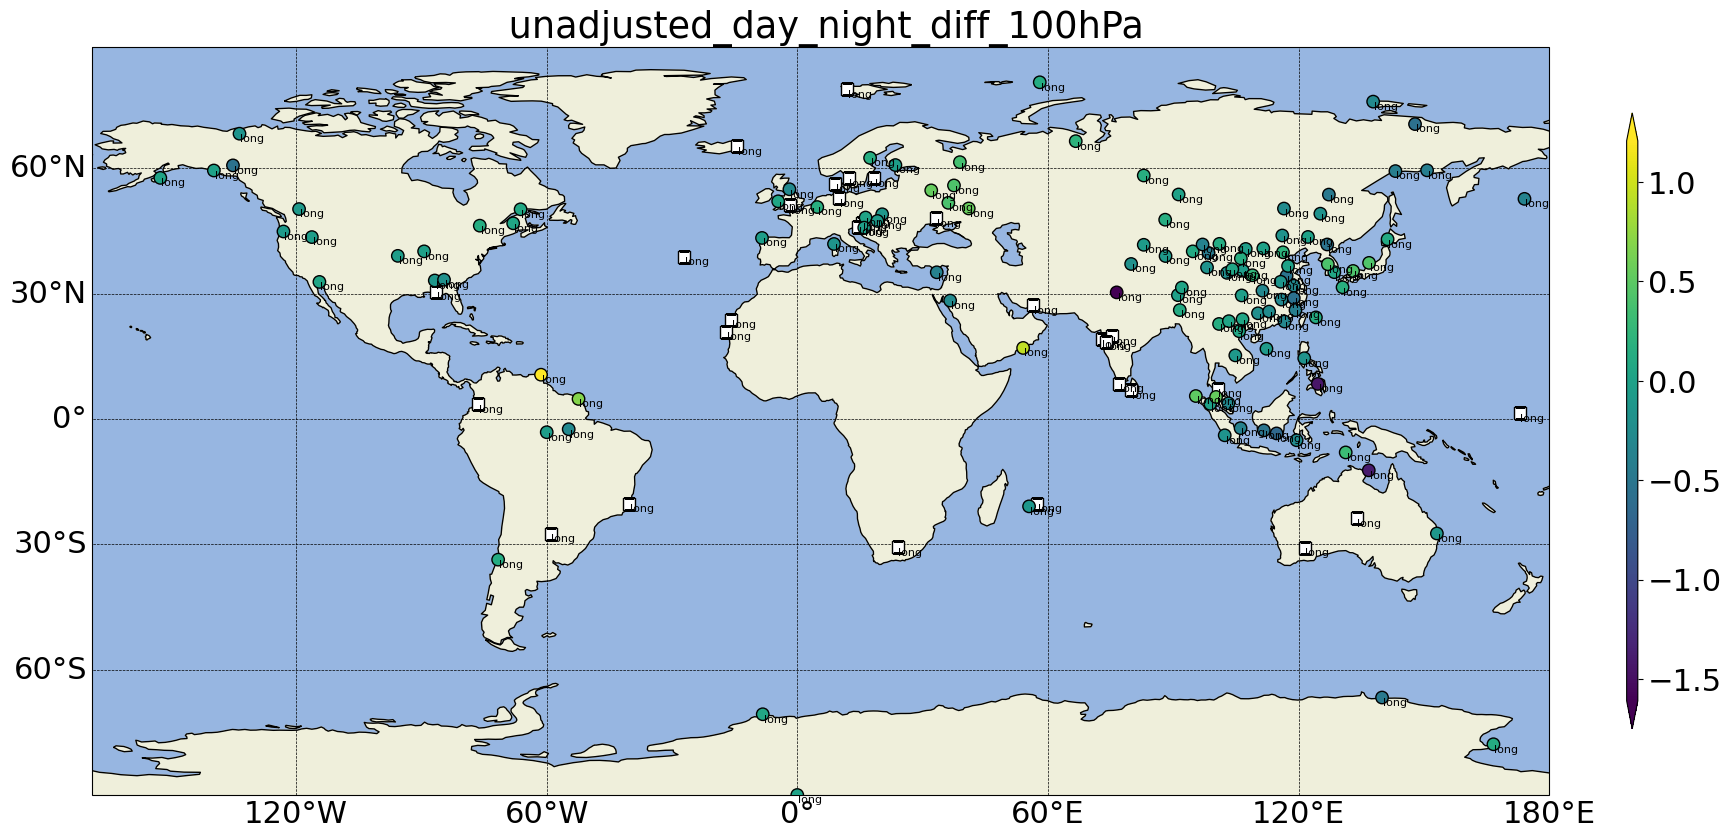

In [8]:
points(lon_list, lat_list, lable_list, value_list, showtitle='unadjusted_day_night_diff_100hPa')

<GeoAxesSubplot:title={'center':' adjusted_day_night_diff_100hPa'}>

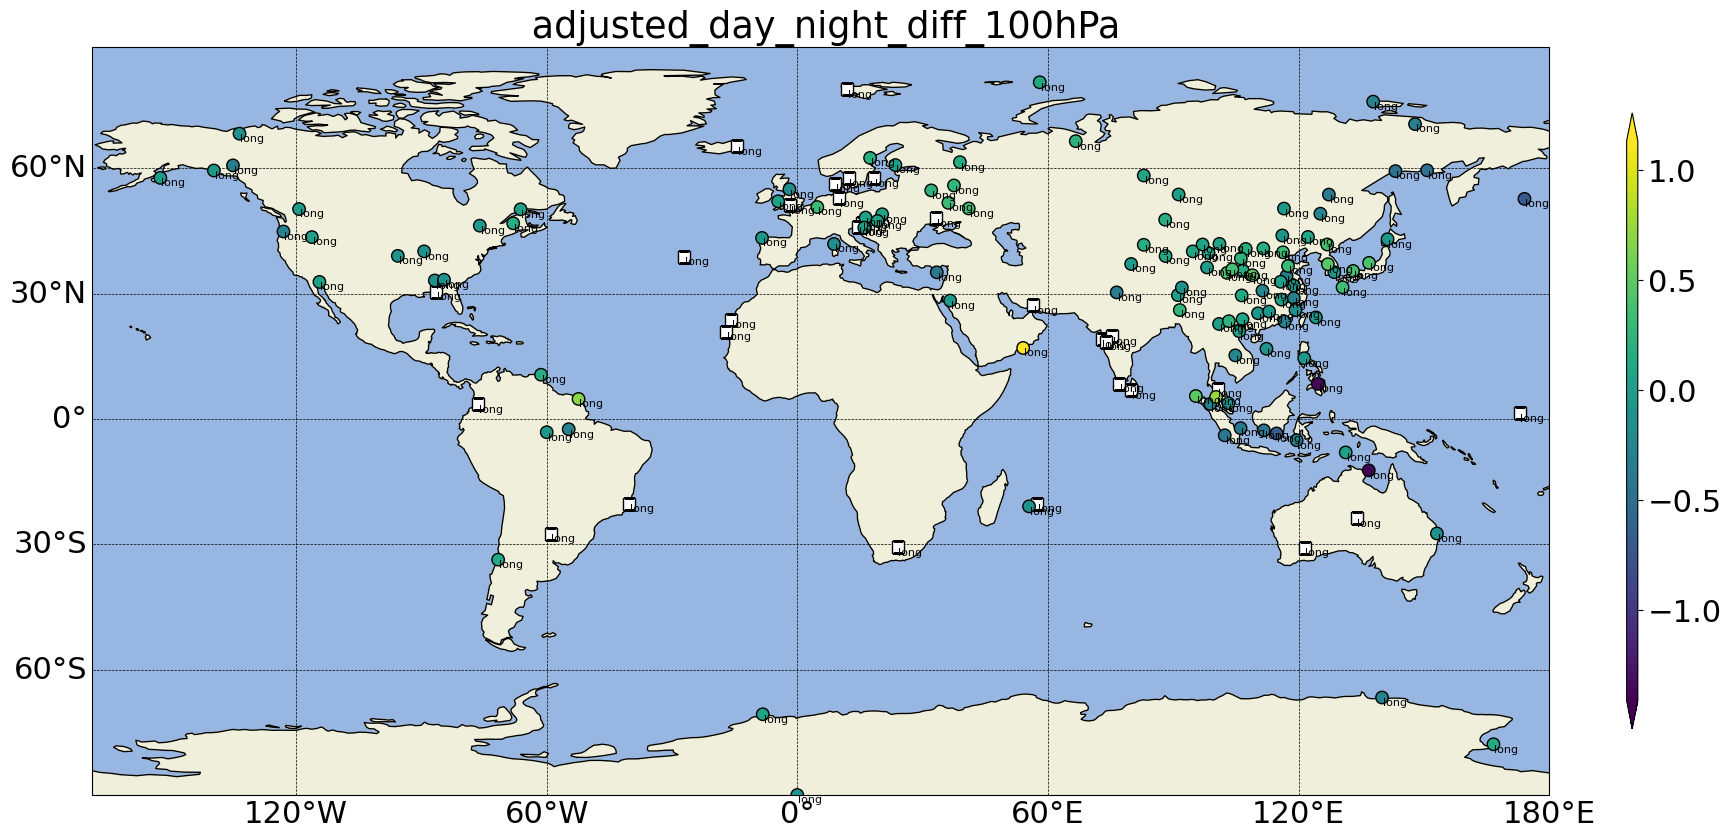

In [9]:
points(lon_list, lat_list, lable_list, value_adjusted_list, showtitle='adjusted_day_night_diff_100hPa')

<GeoAxesSubplot:title={'center':' mean_noon_adjustment_100hPa'}>

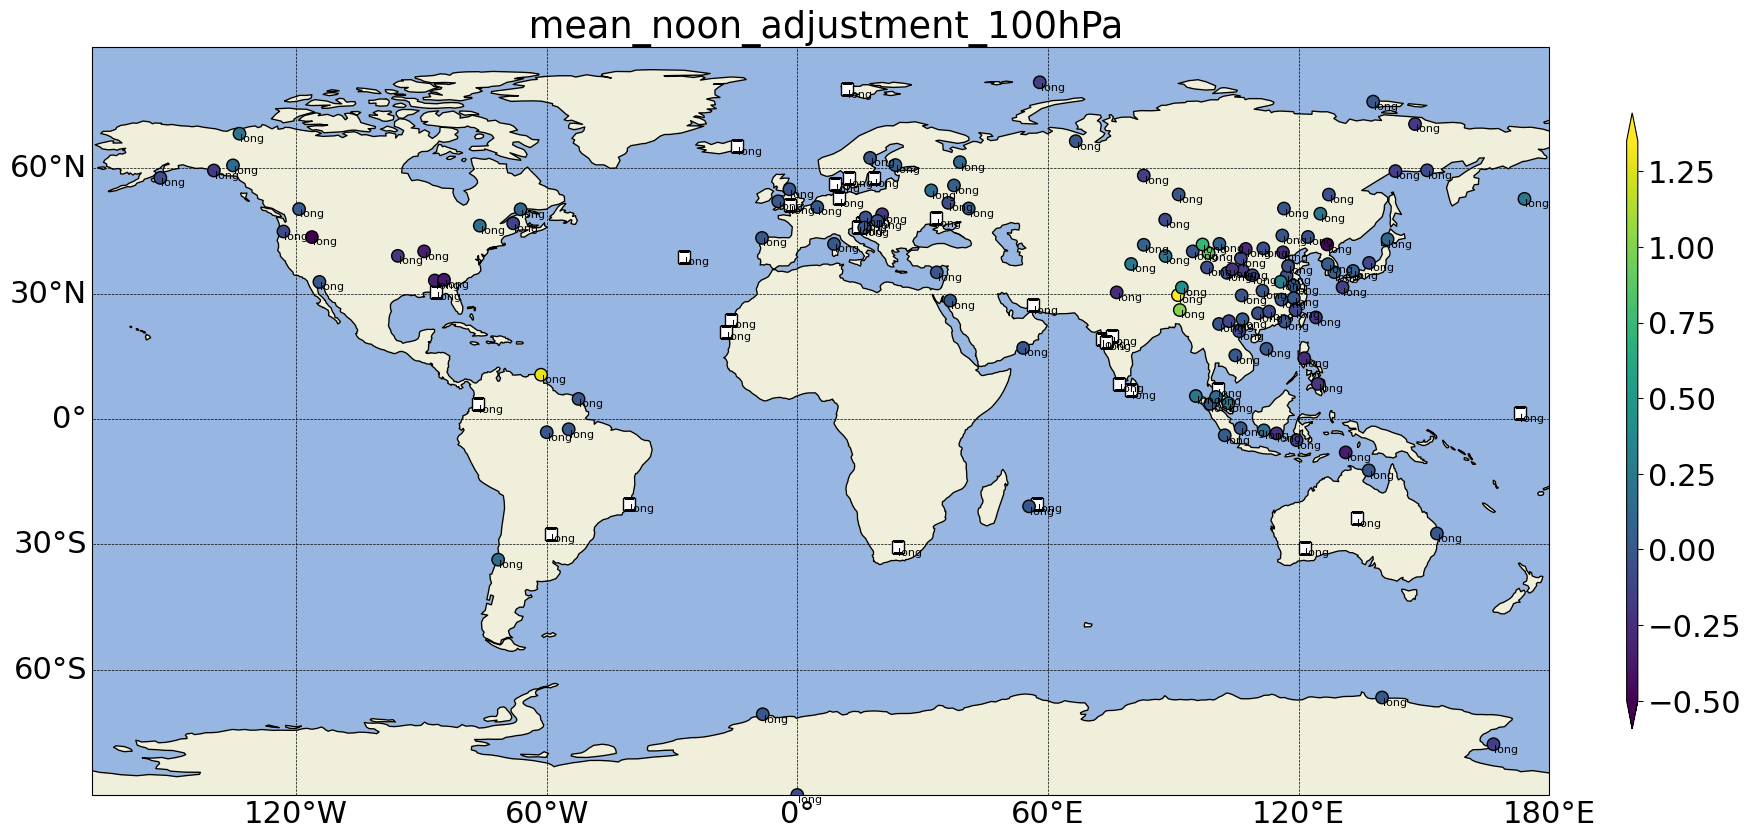

In [10]:
points(lon_list, lat_list, lable_list, mean_noon_adjustment_list, showtitle='mean_noon_adjustment_100hPa')

<GeoAxesSubplot:title={'center':' mean_midnight_adjustment_100hPa'}>

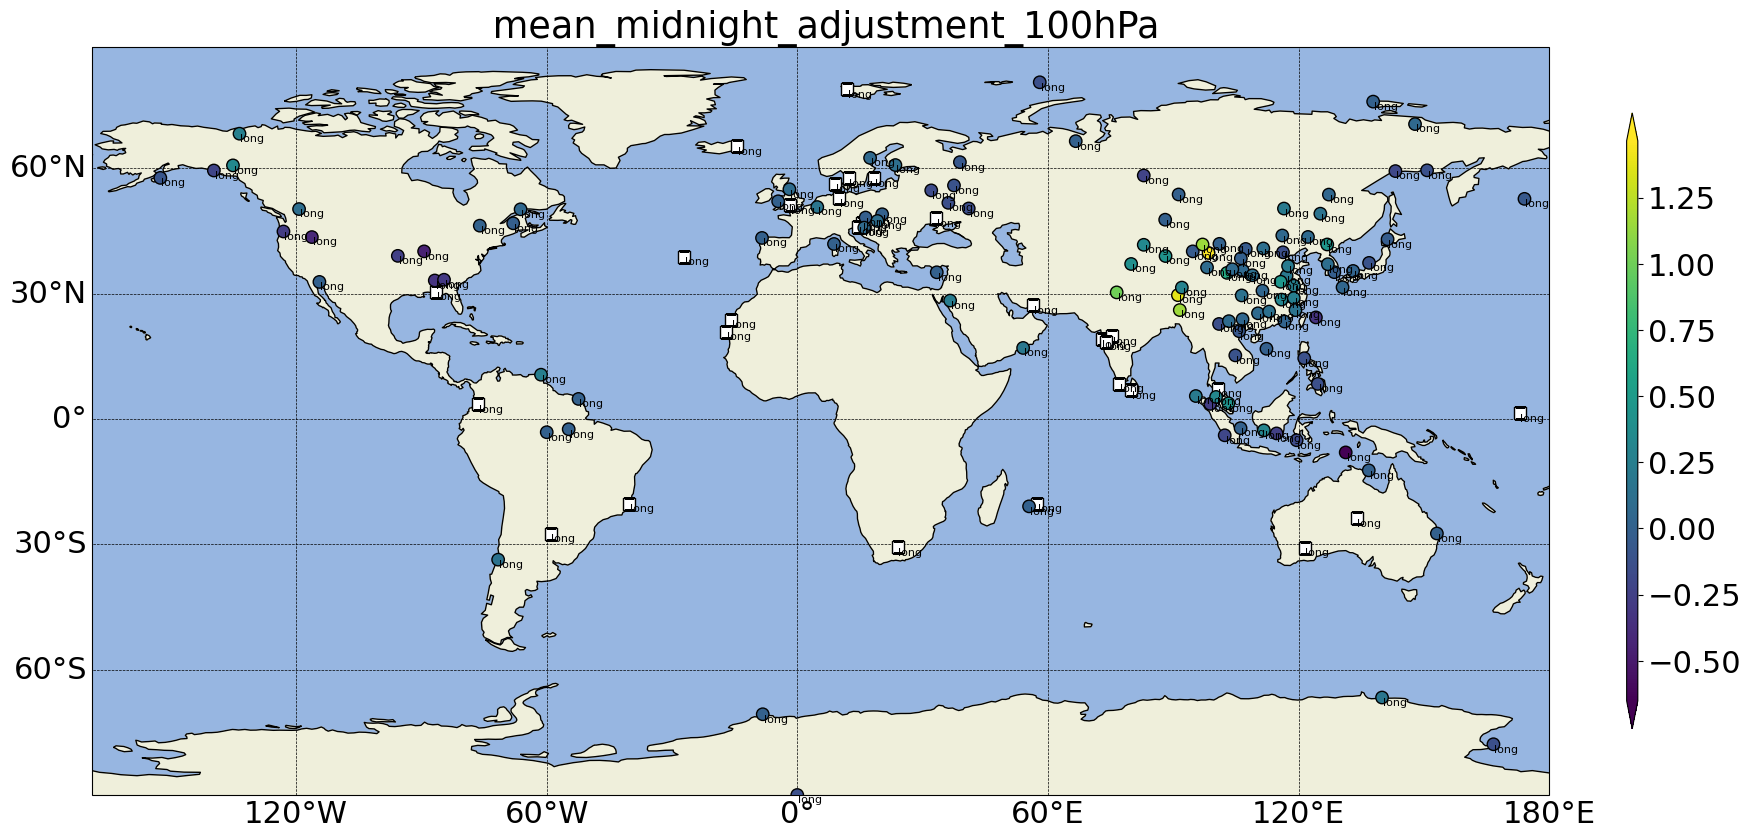

In [11]:
points(lon_list, lat_list, lable_list, mean_midnight_adjustment_list, showtitle='mean_midnight_adjustment_100hPa')

In [19]:
rq = {'variable': 'air_temperature', 'statid': '0-20999*', 'date': '19781001-19781031'}
df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

In [26]:
counter = 0
for i in df:
    if counter < 3:
        display(df[i])
    counter += 1
print(counter)

File: <HDF5 file "dest_0-20999-0-C7R_air_temperature.nc" (mode r)>
Filesize: 0.04 MB
Filename: ./dest_0-20999-0-C7R_air_temperature.nc
(G)roups/(V)ariables: 

 - V | lat__________________________________________ : : (1765,)
 - V | lon__________________________________________ : : (1765,)
 - V | obs__________________________________________ : : (1765,)
 - V | plev_________________________________________ : : (1765,)
 - V | report_id____________________________________ : : (1765, 21)
 - V | station_id___________________________________ : : (1765, 21)
 - V | ta___________________________________________ : : (1765,)
 - V | time_________________________________________ : : (1765,)

File: <HDF5 file "dest_0-20999-0-C7P_air_temperature.nc" (mode r)>
Filesize: 0.04 MB
Filename: ./dest_0-20999-0-C7P_air_temperature.nc
(G)roups/(V)ariables: 

 - V | lat__________________________________________ : : (1863,)
 - V | lon__________________________________________ : : (1863,)
 - V | obs__________________________________________ : : (1863,)
 - V | plev_________________________________________ : : (1863,)
 - V | report_id____________________________________ : : (1863, 21)
 - V | station_id___________________________________ : : (1863, 21)
 - V | ta___________________________________________ : : (1863,)
 - V | time_________________________________________ : : (1863,)

File: <HDF5 file "dest_0-20999-0-20744_air_temperature.nc" (mode r)>
Filesize: 0.04 MB
Filename: ./dest_0-20999-0-20744_air_temperature.nc
(G)roups/(V)ariables: 

 - V | lat__________________________________________ : : (2018,)
 - V | lon__________________________________________ : : (2018,)
 - V | obs__________________________________________ : : (2018,)
 - V | plev_________________________________________ : : (2018,)
 - V | report_id____________________________________ : : (2018, 21)
 - V | station_id___________________________________ : : (2018, 21)
 - V | ta___________________________________________ : : (2018,)
 - V | time_________________________________________ : : (2018,)

9


In [27]:
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as json_file:
    data = json.load(json_file)
    
slnum = list(data.keys())
len(list(filter(lambda x: '20999' in x, slnum)))

7080

In [9]:
rq = {'variable': ['air_temperature'], 'bbox': '20999-coordinate-orphan_HRT2006080518', 'format': 'nc'} # 0-20999-0-ZEKG
df = eua.vm_request_wrapper(rq , overwrite=True , vm_url='http://127.0.0.1:8007')

df.to_dataframe()

lat   lon  obs     plev        report_id station_id          ta  \
0    16.969999  7.98    0   1700.0  900000000000005          0  222.800003   
1    16.969999  7.98    0   1770.0  900000000000005          0  221.199997   
2    16.969999  7.98    0   1840.0  900000000000005          0  221.199997   
3    16.969999  7.98    0   1910.0  900000000000005          0  221.600006   
4    16.969999  7.98    0   1990.0  900000000000005          0  222.699997   
..         ...   ...  ...      ...              ...        ...         ...   
698  16.969999  7.98    0  98160.0  900000000000005          0  302.500000   
699  16.969999  7.98    0  98250.0  900000000000005          0  302.700012   
700  16.969999  7.98    0  98350.0  900000000000005          0  302.700012   
701  16.969999  7.98    0  98420.0  900000000000005          0  302.799988   
702  16.969999  7.98    0  98600.0  900000000000005          0  303.200012   

                   time  
0   2006-08-05 21:00:00  
1   2006-08-05 21:00:00  
2   2006-08-05 21:00:00  
3   2006-08-05 21:00:00  
4   2006-08-05 21:00:00  
..                  ...  
698 2006-08-05 21:00:00  
699 2006-08-05 21:00:00  
700 2006-08-05 21:00:00  
701 2006-08-05 21:00:00  
702 2006-08-05 21:00:00  

[703 rows x 8 columns]